In [1]:
# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from glob import glob
from math import sqrt, ceil, atan2, degrees
import json
from sklearn.cluster import KMeans
from astropy.io import fits
from sklearn.model_selection import train_test_split
import shutil
import time
import torch
from torch.nn import functional as F
import pickle
import copy
from typing import Dict, List
from pathlib import Path
from shapely.geometry import Polygon
import math
from math import radians
from tqdm import tqdm
from sympy.solvers import solve
from sympy import Symbol
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

In [36]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Thu Aug 26 10:14:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:17:00.0 Off |                  N/A |
| 32%   34C    P8    23W / 250W |   9891MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
              

In [3]:
os.environ['MKL_THREADING_LAYER'] = 'GNU'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qkxaiolq
     |████████████████████████████████| 5.6 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 9.1 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 42.0 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 145 kB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 47.0 MB/s eta 0:00:01
  Using cached Cython-0.29.24-cp38-cp38-manylinux1_x86_64.whl (1.9 MB)
     |████████████████████████████████| 97 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 48.9 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 45.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 45.5 MB/s eta 0:00:01
     |██

In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2.data.transforms import RandomFlip
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase, LRScheduler, hooks
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, Metadata, build_detection_train_loader, DatasetMapper
from detectron2.structures import BoxMode, Boxes, Instances, RotatedBoxes, pairwise_iou
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, _log_classification_stats
from detectron2.layers import cat, ShapeSpec
from detectron2.modeling import ROI_HEADS_REGISTRY, PROPOSAL_GENERATOR_REGISTRY, StandardROIHeads, build_model, BACKBONE_REGISTRY, Backbone, ShapeSpec
from detectron2.modeling.proposal_generator import RPN
from detectron2.modeling.proposal_generator.rrpn import RRPN
from detectron2.modeling.roi_heads.box_head import build_box_head
from detectron2.modeling.roi_heads.box_head import build_box_head
from detectron2.modeling.roi_heads.rotated_fast_rcnn import RROIHeads
from detectron2.utils.events import get_event_storage
from detectron2.modeling.box_regression import _dense_box_regression_loss
import detectron2.utils.comm as comm
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.checkpoint import DetectionCheckpointer

In [25]:
for idx, path in enumerate(tqdm(sorted(glob('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/*.json'), key=lambda x: (int(x.split('_')[-9][-3:]), int(x.split('_')[-6][1:]), int(x.split('_')[-7]), int(x.split('_')[-4]))))):
    shutil.copy(path, '/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/json_data/' + str(idx) + '.json')

100%|██████████| 1000/1000 [00:03<00:00, 315.38it/s]


In [121]:
for idx, path in enumerate(tqdm(sorted(glob('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/*[!l].png'), key=lambda x: (int(x.split('_')[-7][-3:]), int(x.split('_')[-4][1:]), int(x.split('_')[-5]), int(x.split('_')[-2]))))):
    image_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image_data = np.flipud(image_data)
    cv2.imwrite('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/png_data/' + str(idx) + '.png', image_data)

100%|██████████| 1000/1000 [00:00<00:00, 1413651.50it/s]

/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/IM_20210221_2201312473197_080_N05_010_0000002_1.png


In [3]:
classes = ['defilant', 'ponctuel', 'star']
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

In [4]:
def show_image(image):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(image)

In [5]:
def get_gt_ponctuel(json_filepath, png_filepath):
    image = {'file_name': png_filepath, 'height': 512, 'width': 512, 'image_id': 0}
    image["annotations"] = []
    image = get_ponctuels(json_filepath, image, 0)
    return image

def get_gt_defilant(json_filepath, png_filepath):
    image = {'file_name': png_filepath, 'height': 512, 'width': 512, 'image_id': 0}
    image["annotations"] = []
    image = get_defilants(json_filepath, image, 0)
    return image

def get_gt_star(csv_filepath, png_filepath):
    image = {'file_name': png_filepath, 'height': 512, 'width': 512, 'image_id': 0}
    image["annotations"] = []
    image = get_stars(csv_filepath, image, 0)
    return image

def get_ponctuels(json_filepath, image, category_id, test=False):
    with open(json_filepath) as json_file:
        objs = []
        data = json.load(json_file)
        satellites = data['Objects']
        for satellite in satellites:
            if satellite['Type'] == 'defilant':
                continue
            obj = {"bbox_mode": BoxMode.XYWH_ABS}
            obj["category_id"] = category_id
            if test:
                obj["snr"] = satellite['snr']
            if satellite['mag'] < 16:
                margin = 4
            else:
                margin = 3
            #margin = -0.92 * satellite['mag'] + 20
            obj["bbox"] = [satellite['x0'] - margin, satellite['y0'] - margin, 2 * margin, 2 * margin]
            objs.append(obj)
        image["annotations"].extend(objs)
    return image

def get_angle(satellite):
    delta_x = satellite['x0'] - satellite['x']
    delta_y = satellite['y'] - satellite['y0']
    return degrees(atan2(delta_y, delta_x))

def get_defilants(json_filepath, image, category_id, test=False):
    with open(json_filepath) as json_file:
        objs = []
        data = json.load(json_file)
        satellites = data['Objects']
        for satellite in satellites:
            if satellite['Type'] != 'defilant':
                continue
            obj = {"bbox_mode": BoxMode.XYWHA_ABS}
            obj["category_id"] = category_id
            if test:
                obj["snr"] = satellite['snr']
            margin = -2 * satellite['mag'] + 28
            angle = get_angle(satellite)
            second_point_coords = (satellite['x0'] + satellite['dx'], satellite['y0'] + satellite['dy'])
            width = sqrt((satellite['x0'] - second_point_coords[0])**2 + (satellite['y0'] - second_point_coords[1])**2) #+ margin
            height = -1.8518 * satellite['mag'] + 29.555
            obj["bbox"] = [satellite['x'], satellite['y'], width, height, angle]
            objs.append(obj)
        image["annotations"].extend(objs)
    return image

def get_stars(csv_filepath, image, category_id):
    df = pd.read_csv(csv_filepath, sep=';', usecols=['X0', 'Y0', 'X1', 'Y1', 'Gmag'])
    df['bbox_mode'] = BoxMode.XYWH_ABS
    df['category_id'] = category_id
    margin = (190 * np.exp(-0.5 * df['Gmag']) + 1)
    width = (df['X0'] - df['X1']) + 2 * margin
    height = (300 * np.exp(-0.4 * df['Gmag']) + 4)
    X = (df['X1'] - margin)
    Y = (df['Y1'] - (height / 2))
    bbox = pd.concat([X, Y, width, height], axis=1)
    df['bbox'] = bbox.values.tolist()
    df.drop(['X0','Y0', 'X1', 'Y1', 'Gmag'], axis=1, inplace=True)
    objs = df.to_dict(orient='records')
    image["annotations"].extend(objs)
    return image

#def get_dataset_all_classes(json_list, png_list, csv_list):
#    dataset = []
#    for idx, (json_filepath, image_filepath, csv_filepath) in enumerate(tqdm(zip(json_list, png_list, csv_list), total=len(json_list), desc='Chargement des datasets')):
#        image = {'file_name': image_filepath, 'height': 512, 'width': 512, 'image_id': idx}
#        image["annotations"] = []
#        image = get_defilants(json_filepath, image, 0)
#        image = get_ponctuels(json_filepath, image, 1)
#        image = get_stars(csv_filepath, image, 2)
#        dataset.append(image)
#    return dataset

def get_dataset_all_classes(json_list, png_list, csv_list):
    dataset = []
    for idx, (json_filepath, image_filepath) in enumerate(tqdm(zip(json_list, png_list), total=len(json_list), desc='Chargement des datasets')):
        image = {'file_name': image_filepath, 'height': 512, 'width': 512, 'image_id': idx}
        image["annotations"] = []
        image = get_defilants(json_filepath, image, 0, True)
        image = get_ponctuels(json_filepath, image, 1, True)
        dataset.append(image)
    return dataset

def get_dataset_ponctuels(json_list, png_list):
    dataset = []
    for idx, (json_filepath, image_filepath) in enumerate(tqdm(zip(json_list, png_list), total=len(json_list), desc='Chargement du dataset ponctuel')):
        image = {'file_name': image_filepath, 'height': 512, 'width': 512, 'image_id': idx}
        image["annotations"] = []
        image = get_ponctuels(json_filepath, image, 0)
        dataset.append(image)
    return dataset

def get_dataset_defilants(json_list, png_list):
    dataset = []
    for idx, (json_filepath, image_filepath) in enumerate(tqdm(zip(json_list, png_list), total=len(json_list), desc='Chargement du dataset defilant')):
        image = {'file_name': image_filepath, 'height': 512, 'width': 512, 'image_id': idx}
        image["annotations"] = []
        image = get_defilants(json_filepath, image, 0)
        dataset.append(image)
    return dataset

def get_dataset_stars(csv_list, png_list):
    dataset = []
    for idx, (csv_filepath, image_filepath) in enumerate(tqdm(zip(csv_list, png_list), total=len(csv_list), desc='Chargement du dataset etoile')):
        image = {'file_name': image_filepath, 'height': 512, 'width': 512, 'image_id': idx}
        image["annotations"] = []
        image = get_stars(csv_filepath, image, 0)
        dataset.append(image)
    return dataset

In [46]:
def get_anchor_parameters(dataset):
    bboxes = []
    ar = []
    mymax = 0
    for image_data in dataset:
        if len(image_data['annotations']) > mymax:
            mymax = len(image_data['annotations'])
        satellites = image_data['annotations']
        for satellite in satellites:
            bboxes.append(np.array([sqrt(satellite['bbox'][2] * satellite['bbox'][3])]).astype(np.float32))
            ar.append(np.array([satellite['bbox'][3] / satellite['bbox'][2]]).astype(np.float32))
    bboxes = np.concatenate(bboxes)
    ar = np.concatenate(ar)
    return bboxes.reshape(-1, 1), mymax, ar.reshape(-1, 1)

In [6]:
def build_lists(path):
    json_list = sorted(glob(os.path.join(path, 'json_data', '*')), key=lambda x: int(x.split('.')[-2].split('/')[-1]))
    csv_list = sorted(glob(os.path.join(path, 'csv_data', '*')), key=lambda x: int(x.split('.')[-2].split('/')[-1]))
    png_list = sorted(glob(os.path.join(path, 'png_data', '*')), key=lambda x: int(x.split('.')[-2].split('/')[-1]))
    print(len(json_list))
    print(len(csv_list))
    print(len(png_list))
    return [json_list, csv_list, png_list]

list_of_files = build_lists('/data_deep/SST_CNES_LOT2/Nouveaux_Datasets')
list_of_files_test = build_lists('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214')
#list_of_files = build_lists('/data_deep/SST_CNES_LOT2/Nouveaux_Datasets')
#list_of_files_test = build_lists('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210628_164525')

14088
14088
14088
1000
1000
1000


In [7]:
def remove_small_mag(list_of_files):
    file_idx_to_remove = []
    list_of_files_new = []
    for idx, filepath in enumerate(list_of_files[0]):
        with open(filepath) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            flag = False
            for satellite in satellites:
                if satellite['Type'] == 'defilant':
                    continue
                elif float(satellite['mag']) > 16.5:
                    flag = True
            if flag and np.random.rand() < 0.1:
                file_idx_to_remove.append(idx)
    for one_list_of_files in list_of_files:
        list_of_files_new.append([x for idx, x in enumerate(one_list_of_files) if idx not in file_idx_to_remove])
    return list_of_files_new

list_of_files = remove_small_mag(list_of_files)

#mag_list = get_mag_list(list_of_files_new[0])
#plt.hist(mag_list, bins=np.arange(min(mag_list), max(mag_list), 0.1), color='blue', edgecolor='red')
#plt.show()

2.7529116909921862
12340
4482.526642746211


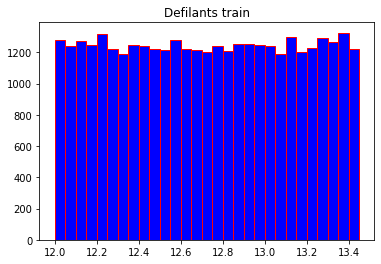

In [8]:
def get_mag_list(list_of_files):
    magnitude_list = []
    nb_defilants = 0
    nb_defilants_to_get = 0
    for filepath in list_of_files:
        with open(filepath) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            for satellite in satellites:
                if satellite['Type'] == 'ponctuel':
                    continue
                nb_defilants += 1
                if float(satellite['mag']) > 12.5 and float(satellite['mag']) < 13:
                    nb_defilants_to_get += 1
                magnitude_list.append(float(satellite['mag']))
    return magnitude_list, nb_defilants / len(list_of_files), nb_defilants_to_get

mag_list, mean_defilant, nb_to_get = get_mag_list(list_of_files[0])
print(mean_defilant)
print(nb_to_get)
print(nb_to_get / mean_defilant)
plt.hist(mag_list, bins=np.arange(min(mag_list), max(mag_list), 0.05), color='blue', edgecolor='red')
plt.title('Defilants train')
plt.show()

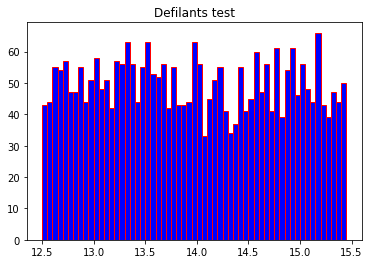

In [9]:
def get_mag_list(list_of_files):
    magnitude_list = []
    for filepath in list_of_files:
        with open(filepath) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            for satellite in satellites:
                if satellite['Type'] == 'ponctuel':
                    continue
                magnitude_list.append(float(satellite['mag']))
    return magnitude_list

mag_list = get_mag_list(list_of_files_test[0])
plt.hist(mag_list, bins=np.arange(min(mag_list), max(mag_list), 0.05), color='blue', edgecolor='red')
plt.title('Defilants test')
plt.show()

2.9939683707245313
33806
11291.368449500036


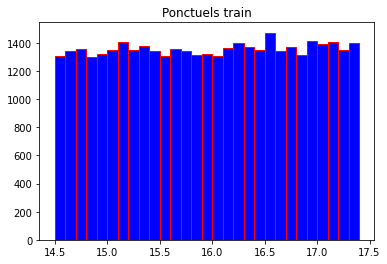

In [9]:
def get_mag_list(list_of_files):
    magnitude_list = []
    nb_ponctuels = 0
    nb_ponctuels_to_get = 0
    for filepath in list_of_files:
        with open(filepath) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            for satellite in satellites:
                if satellite['Type'] == 'defilant':
                    continue
                nb_ponctuels += 1
                if float(satellite['mag']) > 14.5 and float(satellite['mag']) < 17:
                    nb_ponctuels_to_get += 1
                magnitude_list.append(float(satellite['mag']))
    return magnitude_list, nb_ponctuels / len(list_of_files), nb_ponctuels_to_get

mag_list, mean_ponctuels, nb_to_get = get_mag_list(list_of_files[0])
print(mean_ponctuels)
print(nb_to_get)
print(nb_to_get / mean_ponctuels)
plt.hist(mag_list, bins=np.arange(min(mag_list), max(mag_list), 0.1), color='blue', edgecolor='red')
plt.title('Ponctuels train')
plt.show()

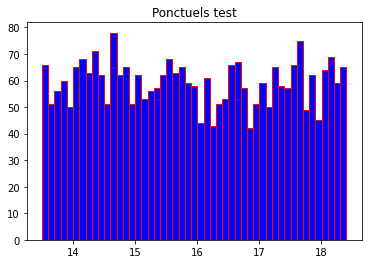

In [19]:
def get_mag_list(list_of_files):
    magnitude_list = []
    for filepath in list_of_files:
        with open(filepath) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            for satellite in satellites:
                if satellite['Type'] == 'defilant':
                    continue
                magnitude_list.append(float(satellite['mag']))
    return magnitude_list

mag_list = get_mag_list(list_of_files_test[0])
plt.hist(mag_list, bins=np.arange(min(mag_list), max(mag_list), 0.1), color='blue', edgecolor='red')
plt.title('Ponctuels test')
plt.show()

In [7]:
def build_list_dict(list_of_files, list_of_files_test):
    out = {}
    all_indices = list(range(len(list_of_files[0])))
    train_indices, test_indices = train_test_split(all_indices, test_size=0.1, random_state=0)
    out['json_val'] = [list_of_files[0][i] for i in test_indices]
    out['png_val'] = [list_of_files[2][i] for i in test_indices]
    out['csv_val'] = [list_of_files[1][i] for i in test_indices]
    out['json_train'] = [list_of_files[0][i] for i in train_indices]
    out['png_train'] = [list_of_files[2][i] for i in train_indices]
    out['csv_train'] = [list_of_files[1][i] for i in train_indices]
    out['json_test'] = list_of_files_test[0]
    out['png_test'] = list_of_files_test[2]
    out['csv_test'] = list_of_files_test[1]
    return out
    
list_dict = build_list_dict(list_of_files, list_of_files_test)

In [8]:
'''def register_datasets_all():
    DatasetCatalog.register('train', lambda : get_dataset_all_classes(json_train, png_train, csv_train))
    DatasetCatalog.register('val', lambda : get_dataset_all_classes(json_val, png_val, csv_val))
    DatasetCatalog.register('test', lambda : get_dataset_all_classes(json_test, png_test, csv_test))
    MetadataCatalog.get("train").set(thing_classes=["defilant", "ponctuel", "etoile"], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255)])
    MetadataCatalog.get("val").set(thing_classes=["defilant", "ponctuel", "etoile"], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255)])
    MetadataCatalog.get("test").set(thing_classes=["defilant", "ponctuel", "etoile"], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255)])
    return MetadataCatalog.get("train")

metadatas = []
functions = [get_dataset_defilants, get_dataset_ponctuels, get_dataset_stars]
info_files = [[json_train, json_val, json_test], [json_train, json_val, json_test], [csv_train, csv_val, csv_test]]
DatasetCatalog.register('test', lambda : get_dataset_all_classes(json_test, png_test, csv_test))
MetadataCatalog.get("test").set(thing_classes=classes, thing_colors=colors)
for func, name, color, info_file in zip(functions, classes, colors, info_files):
    for part in ['train', 'val', 'test']:
        dataset_name = part + '_' + name
        DatasetCatalog.register(dataset_name, lambda : func(info_file[0], png_train))
        MetadataCatalog.get(dataset_name).set(thing_classes=[name], thing_colors=[color])
        if part == 'train':
            metadatas.append(MetadataCatalog.get(dataset_name))'''

def register_dataset_test(list_dict):
    DatasetCatalog.register('test', lambda : get_dataset_all_classes(list_dict['json_test'], list_dict['png_test'], list_dict['csv_test']))
    MetadataCatalog.get("test").set(thing_classes=["defilant", "ponctuel", "star"], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255)])
    return MetadataCatalog.get("test")

def register_datasets_defilant(list_dict):
    DatasetCatalog.register('train_defilant', lambda : get_dataset_defilants(list_dict['json_train'], list_dict['png_train']))
    DatasetCatalog.register('val_defilant', lambda : get_dataset_defilants(list_dict['json_val'], list_dict['png_val']))
    DatasetCatalog.register('test_defilant', lambda : get_dataset_defilants(list_dict['json_test'], list_dict['png_test']))
    MetadataCatalog.get("train_defilant").set(thing_classes=["defilant"], thing_colors=[(255, 0, 0)])
    MetadataCatalog.get("val_defilant").set(thing_classes=["defilant"], thing_colors=[(255, 0, 0)])
    MetadataCatalog.get("test_defilant").set(thing_classes=["defilant"], thing_colors=[(255, 0, 0)])
    return MetadataCatalog.get("train_defilant")

def register_datasets_ponctuel(list_dict):
    DatasetCatalog.register('train_ponctuel', lambda : get_dataset_ponctuels(list_dict['json_train'], list_dict['png_train']))
    DatasetCatalog.register('val_ponctuel', lambda : get_dataset_ponctuels(list_dict['json_val'], list_dict['png_val']))
    DatasetCatalog.register('test_ponctuel', lambda : get_dataset_ponctuels(list_dict['json_test'], list_dict['png_test']))
    MetadataCatalog.get("train_ponctuel").set(thing_classes=["ponctuel"], thing_colors=[(0, 255, 0)])
    MetadataCatalog.get("val_ponctuel").set(thing_classes=["ponctuel"], thing_colors=[(0, 255, 0)])
    MetadataCatalog.get("test_ponctuel").set(thing_classes=["ponctuel"], thing_colors=[(0, 255, 0)])
    return MetadataCatalog.get("train_ponctuel")

def register_datasets_star(list_dict):
    DatasetCatalog.register('train_star', lambda : get_dataset_stars(list_dict['csv_train'], list_dict['png_train']))
    DatasetCatalog.register('val_star', lambda : get_dataset_stars(list_dict['csv_val'], list_dict['png_val']))
    DatasetCatalog.register('test_star', lambda : get_dataset_stars(list_dict['csv_test'], list_dict['png_test']))
    MetadataCatalog.get("train_star").set(thing_classes=["etoile"], thing_colors=[(0, 0, 255)])
    MetadataCatalog.get("val_star").set(thing_classes=["etoile"], thing_colors=[(0, 0, 255)])
    MetadataCatalog.get("test_star").set(thing_classes=["etoile"], thing_colors=[(0, 0, 255)])
    return MetadataCatalog.get("train_star")

metadatas = register_dataset_test(list_dict)
metadata_defilant = register_datasets_defilant(list_dict)
metadata_ponctuel = register_datasets_ponctuel(list_dict)
metadata_star = register_datasets_star(list_dict)
#metadatas = [metadata_defilant, metadata_ponctuel, metadata_star]
#metadatas = [metadata_defilant, metadata_ponctuel]

In [14]:
def get_aspect_ratios(labels, ar, tool_dict):
    aspect_ratios = []
    for i in tool_dict.keys():
        kmeans = KMeans(n_clusters=3, random_state=0).fit(ar[labels == i])
        aspect_ratios.append(sorted(kmeans.cluster_centers_.reshape(-1,).tolist()))
    return aspect_ratios

In [17]:
def get_max_detections_and_anchor_sizes_all():
    bboxes_train, max_train, ar_train = get_anchor_parameters(DatasetCatalog.get("train"))
    bboxes_val, max_val, ar_val = get_anchor_parameters(DatasetCatalog.get("val"))
    bboxes_test, max_test, ar_test = get_anchor_parameters(DatasetCatalog.get("test"))
    max_detections = max(max_train, max_val, max_test)
    bboxes = np.concatenate([bboxes_train, bboxes_test, bboxes_val])
    ar = np.concatenate([ar_train, ar_test, ar_val])
    anchor_sizes = []
    kmeans = KMeans(n_clusters=5, random_state=0).fit(bboxes)
    tool_dict = {
        0: kmeans.cluster_centers_[0],
        1: kmeans.cluster_centers_[1],
        2: kmeans.cluster_centers_[2],
        3: kmeans.cluster_centers_[3], 
        4: kmeans.cluster_centers_[4]
        }
    tool_dict = {k: v for k, v in sorted(tool_dict.items(), key=lambda item: item[1])}
    aspect_ratios = get_aspect_ratios(kmeans.labels_, ar, tool_dict)
    [anchor_sizes.append(x.tolist()) for x in kmeans.cluster_centers_]
    anchor_sizes = sorted(anchor_sizes, key=lambda x: x[0])
    anchor_sizes = [[ceil(x[0])] for x in anchor_sizes]
    return max_detections, anchor_sizes, aspect_ratios

def get_max_detections_and_anchor_sizes_classes():
    anchor_sizes_classes = []
    max_detections_classes = []
    aspect_ratios = []
    for name in classes:
        bboxes_train, max_train, ar_train = get_anchor_parameters(DatasetCatalog.get("train_" + name))
        bboxes_val, max_val, ar_val = get_anchor_parameters(DatasetCatalog.get("val_" + name))
        bboxes_test, max_test, ar_test = get_anchor_parameters(DatasetCatalog.get("test_" + name))
        max_detections = max(max_train, max_val, max_test)
        bboxes = np.concatenate([bboxes_train, bboxes_test, bboxes_val])
        ar = np.concatenate([ar_train, ar_test, ar_val])
        anchor_sizes = []
        aspect_ratio = []
        values_boxes = np.unique(bboxes)
        values_ratios = np.unique(ar)
        if name != 'ponctuel':
            kmeans = KMeans(n_clusters=5, random_state=0).fit(bboxes)
            tool_dict = {
                0: kmeans.cluster_centers_[0],
                1: kmeans.cluster_centers_[1],
                2: kmeans.cluster_centers_[2],
                3: kmeans.cluster_centers_[3], 
                4: kmeans.cluster_centers_[4]
                }
            tool_dict = {k: v for k, v in sorted(tool_dict.items(), key=lambda item: item[1])}
            aspect_ratio = get_aspect_ratios(kmeans.labels_, ar, tool_dict)
            [anchor_sizes.append(x.tolist()) for x in kmeans.cluster_centers_]
        anchor_sizes = sorted(anchor_sizes, key=lambda x: x[0])
        anchor_sizes = [[ceil(x[0])] for x in anchor_sizes]
        anchor_sizes_classes.append(anchor_sizes)
        max_detections_classes.append(max_detections)
        aspect_ratios.append(aspect_ratio)

    return max_detections_classes, anchor_sizes_classes, aspect_ratios

#max_detections, anchor_sizes, aspect_ratios = get_max_detections_and_anchor_sizes_all()
max_detections_classes, anchor_sizes_classes, aspect_ratios_classes = get_max_detections_and_anchor_sizes_classes()
print(max_detections_classes)
print(anchor_sizes_classes)

[7]
[[[16], [21], [25], [29], [34]]]


In [9]:
def _create_text_labels(classes, scores, class_names, is_crowd=None):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):
        is_crowd (list[bool] or None):
    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None:
        if class_names is not None and len(class_names) > 0:
            labels = [class_names[i] for i in classes]
        else:
            labels = [str(i) for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    if labels is not None and is_crowd is not None:
        labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
    return labels

class MyVisualizer(Visualizer):
    def draw_instance_predictions(self, predictions):
        """
        Draw instance-level prediction results on an image.
        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").
        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                [x / 255 for x in self.metadata.thing_colors[c]] for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(
                (predictions.pred_masks.any(dim=0) > 0).numpy()
                if predictions.has("pred_masks")
                else None
            )
            alpha = 0.3
        
        labels = None
        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output
    
    def draw_dataset_dict(self, dic):
        """
        Draw annotations/segmentaions in Detectron2 Dataset format.
        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.
        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [
                BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS)
                if len(x["bbox"]) == 4
                else x["bbox"]
                for x in annos
            ]

            colors = None
            category_ids = [x["category_id"] for x in annos]
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    [x / 255 for x in self.metadata.thing_colors[c]]
                    for c in category_ids
                ]
            names = self.metadata.get("thing_classes", None)
            labels = _create_text_labels(
                category_ids,
                scores=None,
                class_names=names,
                is_crowd=[x.get("iscrowd", 0) for x in annos],
            )
            self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            with PathManager.open(dic["sem_seg_file_name"], "rb") as f:
                sem_seg = Image.open(f)
                sem_seg = np.asarray(sem_seg, dtype="uint8")
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)

        pan_seg = dic.get("pan_seg", None)
        if pan_seg is None and "pan_seg_file_name" in dic:
            with PathManager.open(dic["pan_seg_file_name"], "rb") as f:
                pan_seg = Image.open(f)
                pan_seg = np.asarray(pan_seg)
                from panopticapi.utils import rgb2id

                pan_seg = rgb2id(pan_seg)
        if pan_seg is not None:
            segments_info = dic["segments_info"]
            pan_seg = torch.tensor(pan_seg)
            self.draw_panoptic_seg(pan_seg, segments_info, area_threshold=0, alpha=0.5)
        return self.output
    
    def draw_rotated_box_with_label(
        self, rotated_box, alpha=0.5, edge_color="g", line_style="-", label=None):
        """
        Draw a rotated box with label on its top-left corner.
        Args:
            rotated_box (tuple): a tuple containing (cnt_x, cnt_y, w, h, angle),
                where cnt_x and cnt_y are the center coordinates of the box.
                w and h are the width and height of the box. angle represents how
                many degrees the box is rotated CCW with regard to the 0-degree box.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
            label (string): label for rotated box. It will not be rendered when set to None.
        Returns:
            output (VisImage): image object with box drawn.
        """
        cnt_x, cnt_y, w, h, angle = rotated_box
        area = w * h
        # use thinner lines when the box is small
        linewidth = self._default_font_size / (
            24 if area < 1000 * self.output.scale else 12
        )

        theta = angle * math.pi / 180.0
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [(s * yy + c * xx + cnt_x, c * yy - s * xx + cnt_y) for (xx, yy) in rect]
        for k in range(4):
            j = (k + 1) % 4
            self.draw_line(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color=edge_color,
                linestyle="--" if k == 1 else line_style,
                linewidth=linewidth,
            )

        if label is not None:
            text_pos = rotated_rect[0]  # topleft corner

            height_ratio = h / np.sqrt(self.output.height * self.output.width)
            label_color = self._change_color_brightness(edge_color, brightness_factor=0.7)
            font_size = (
                np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2) * 0.5 * self._default_font_size
            )
            self.draw_text(label, text_pos, color=label_color, font_size=font_size, rotation=angle)

        return self.output

/data_deep/SST_CNES_LOT2/Nouveaux_Datasets/png_data/8898.png
CPU times: user 373 ms, sys: 18.5 ms, total: 391 ms
Wall time: 462 ms


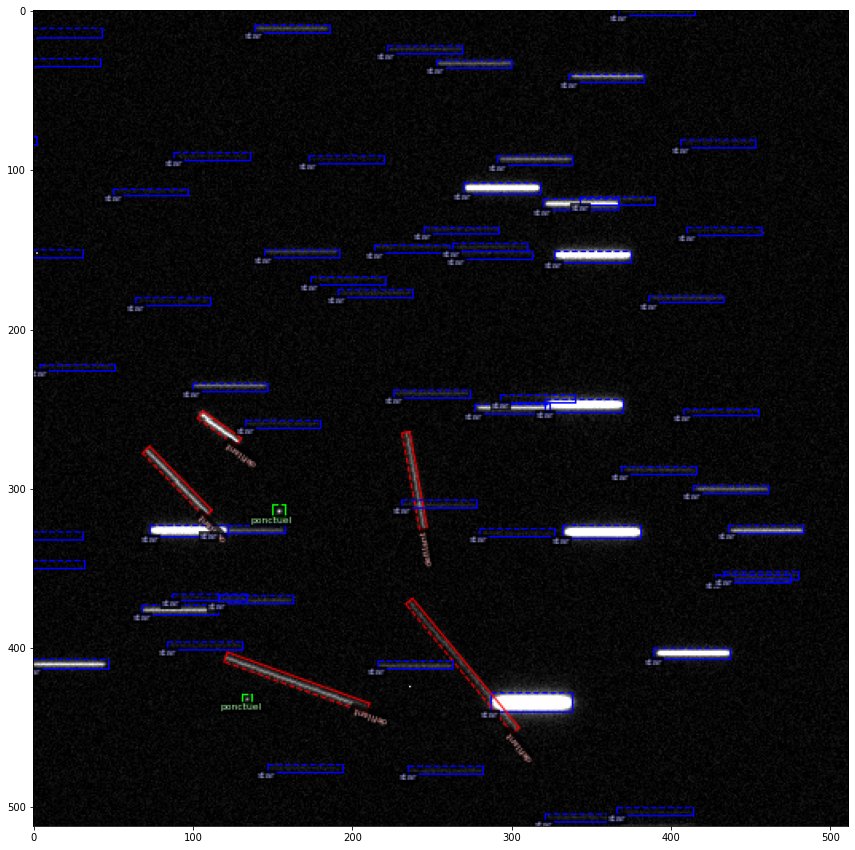

In [10]:
%%time

def display_classes(list_of_files_new, metadatas):
    
    random_index = np.random.randint(0, len(list_of_files_new[0]), 1)[0]
    data_defilant = get_gt_defilant(list_of_files_new[0][random_index], list_of_files_new[2][random_index])
    data_ponctuel = get_gt_ponctuel(list_of_files_new[0][random_index], list_of_files_new[2][random_index])
    data_star = get_gt_star(list_of_files_new[1][random_index], list_of_files_new[2][random_index])
    print(data_ponctuel["file_name"])
    
    output = {'file_name': data_defilant["file_name"], 'height': 512, 'width': 512, 'image_id': 0}
    objs = []
    for obj_star in data_star['annotations']:
        obj_data_star = {}
        obj_data_star['bbox'] = BoxMode.convert(obj_star['bbox'], obj_star['bbox_mode'], BoxMode.XYWHA_ABS)
        obj_data_star['bbox_mode'] = BoxMode.XYWHA_ABS
        obj_data_star['category_id'] = 2
        objs.append(obj_data_star)
    for obj_ponctuel in data_ponctuel['annotations']:
        obj_data_ponctuel = {}
        obj_data_ponctuel['bbox'] = BoxMode.convert(obj_ponctuel['bbox'], obj_ponctuel['bbox_mode'], BoxMode.XYWHA_ABS)
        obj_data_ponctuel['bbox_mode'] = BoxMode.XYWHA_ABS
        obj_data_ponctuel['category_id'] = 1
        objs.append(obj_data_ponctuel)
    for obj_defilant in data_defilant['annotations']:
        obj_data_defilant = {}
        obj_data_defilant['bbox'] = BoxMode.convert(obj_defilant['bbox'], obj_defilant['bbox_mode'], BoxMode.XYWHA_ABS)
        obj_data_defilant['bbox_mode'] = BoxMode.XYWHA_ABS
        obj_data_defilant['category_id'] = 0
        objs.append(obj_data_defilant)
    output['annotations'] = objs
    img = cv2.imread(data_ponctuel["file_name"], cv2.IMREAD_COLOR)
    visualizer = MyVisualizer(img, metadata=metadatas, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    out = visualizer.draw_dataset_dict(output)
    cv2.imwrite('/data_deep/SST_CNES_LOT2/gt_image_example.png', out.get_image())
    show_image(out.get_image())

metadatas = Metadata()
metadatas.thing_classes = classes
metadatas.thing_colors = colors
display_classes(list_of_files, metadatas)

In [11]:
def my_cross_entropy(input, target, *, reduction="mean", **kwargs):
    """
    Same as `torch.nn.functional.cross_entropy`, but returns 0 (instead of nan)
    for empty inputs.
    """
    if target.numel() == 0 and reduction == "mean":
        return input.sum() * 0.0  # connect the gradient

    nb_of_one = torch.tensor([(target == 1).sum()]) if (target == 1).sum() > 0 else torch.tensor([1])
    nb_of_zero = torch.tensor([(target == 0).sum()]) if (target == 0).sum() > 0 else torch.tensor([1])
    #weights = (1 / torch.cat((nb_of_zero, nb_of_one))).to('cuda:0')
    weights = (torch.cat((nb_of_one, nb_of_zero)) / (nb_of_one + nb_of_zero)).to('cuda:0')
    #return F.cross_entropy(input, target, weight=weights, **kwargs)
    #return F.cross_entropy(input, target, **kwargs)
    return focal_loss_multiclass(input, target, alphas=weights, gamma=2, reduction=reduction)
    #new_target = (~(target.type(torch.bool))).type(torch.float32)
    #return sigmoid_focal_loss(input[:, 0].reshape(target.shape), new_target, alpha=-1, gamma=1, reduction=reduction)

def focal_loss_multiclass(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alphas: torch.Tensor,
    gamma: float = 1,
    reduction: str = "none",
) -> torch.Tensor:

    log_prob = F.log_softmax(inputs, dim=-1)
    prob = torch.exp(log_prob)
    return F.nll_loss(((1 - prob) ** gamma) * log_prob, targets, weight=alphas, reduction=reduction)

def focal_loss_multiclass2(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alphas: torch.Tensor,
    gamma: float = 1,
    reduction: str = "none",
) -> torch.Tensor:

    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    p_t = torch.exp(-ce_loss)

    loss = ce_loss * ((1 - p_t) ** gamma)

    if (~torch.all(alphas == alphas[0], dim=0)).item():
        alpha_t = torch.gather(alphas, 0, targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

def focal_loss_binary(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """

    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

class MyRCNNOutput(FastRCNNOutputLayers):
    def __init__(self, cfg, input_shape):
        super().__init__(cfg, input_shape)

    def losses(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_boxes``,
                ``gt_classes`` are expected.
        Returns:
            Dict[str, Tensor]: dict of losses
        """
        scores, proposal_deltas = predictions

        # parse classification outputs
        gt_classes = (
            cat([p.gt_classes for p in proposals], dim=0) if len(proposals) else torch.empty(0)
        )
        _log_classification_stats(scores, gt_classes)

        # parse box regression outputs
        if len(proposals):
            proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)  # Nx4
            assert not proposal_boxes.requires_grad, "Proposals should not require gradients!"
            # If "gt_boxes" does not exist, the proposals must be all negative and
            # should not be included in regression loss computation.
            # Here we just use proposal_boxes as an arbitrary placeholder because its
            # value won't be used in self.box_reg_loss().
            gt_boxes = cat(
                [(p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes).tensor for p in proposals],
                dim=0,
            )
        else:
            proposal_boxes = gt_boxes = torch.empty((0, 4), device=proposal_deltas.device)

        losses = {
            "loss_cls": my_cross_entropy(scores, gt_classes, reduction="mean"),
            "loss_box_reg": self.box_reg_loss(
                proposal_boxes, gt_boxes, proposal_deltas, gt_classes
            ),
        }
        return {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}

In [12]:
@ROI_HEADS_REGISTRY.register()
class MyStandardROIHeads(StandardROIHeads):
    def __init__(self, cfg, input_shape):
        in_features       = cfg.MODEL.ROI_HEADS.IN_FEATURES
        pooler_resolution = cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION
        # fmt: on

        # If StandardROIHeads is applied on multiple feature maps (as in FPN),
        # then we share the same predictors and therefore the channel counts must be the same
        in_channels = [input_shape[f].channels for f in in_features]
        # Check all channel counts are equal
        assert len(set(in_channels)) == 1, in_channels
        in_channels = in_channels[0]

        # Here we split "box head" and "box predictor", which is mainly due to historical reasons.
        # They are used together so the "box predictor" layers should be part of the "box head".
        # New subclasses of ROIHeads do not need "box predictor"s.
        box_head = build_box_head(
            cfg, ShapeSpec(channels=in_channels, height=pooler_resolution, width=pooler_resolution)
        )
        my_box_predictor = MyRCNNOutput(cfg, box_head.output_shape)
        super().__init__(cfg, input_shape, box_predictor=my_box_predictor)

@PROPOSAL_GENERATOR_REGISTRY.register()
class MyRPN(RPN):
    def __init__(self, cfg, input_shape):
        super().__init__(cfg, input_shape)

    @torch.jit.unused
    def losses(
        self,
        anchors: List[Boxes],
        pred_objectness_logits: List[torch.Tensor],
        gt_labels: List[torch.Tensor],
        pred_anchor_deltas: List[torch.Tensor],
        gt_boxes: List[torch.Tensor],
    ) -> Dict[str, torch.Tensor]:
        """
        Return the losses from a set of RPN predictions and their associated ground-truth.
        Args:
            anchors (list[Boxes or RotatedBoxes]): anchors for each feature map, each
                has shape (Hi*Wi*A, B), where B is box dimension (4 or 5).
            pred_objectness_logits (list[Tensor]): A list of L elements.
                Element i is a tensor of shape (N, Hi*Wi*A) representing
                the predicted objectness logits for all anchors.
            gt_labels (list[Tensor]): Output of :meth:`label_and_sample_anchors`.
            pred_anchor_deltas (list[Tensor]): A list of L elements. Element i is a tensor of shape
                (N, Hi*Wi*A, 4 or 5) representing the predicted "deltas" used to transform anchors
                to proposals.
            gt_boxes (list[Tensor]): Output of :meth:`label_and_sample_anchors`.
        Returns:
            dict[loss name -> loss value]: A dict mapping from loss name to loss value.
                Loss names are: `loss_rpn_cls` for objectness classification and
                `loss_rpn_loc` for proposal localization.
        """
        num_images = len(gt_labels)
        gt_labels = torch.stack(gt_labels)  # (N, sum(Hi*Wi*Ai))

        # Log the number of positive/negative anchors per-image that's used in training
        pos_mask = gt_labels == 1
        num_pos_anchors = pos_mask.sum().item()
        num_neg_anchors = (gt_labels == 0).sum().item()
        storage = get_event_storage()
        storage.put_scalar("rpn/num_pos_anchors", num_pos_anchors / num_images)
        storage.put_scalar("rpn/num_neg_anchors", num_neg_anchors / num_images)

        localization_loss = _dense_box_regression_loss(
            anchors,
            self.box2box_transform,
            pred_anchor_deltas,
            gt_boxes,
            pos_mask,
            box_reg_loss_type=self.box_reg_loss_type,
            smooth_l1_beta=self.smooth_l1_beta,
        )

        valid_mask = gt_labels >= 0

        #target = gt_labels[valid_mask].to(torch.float32)

        #nb_of_one = torch.tensor([(target == 1.).sum()]) if (target == 1.).sum() > 0 else torch.tensor([1])
        #nb_of_zero = torch.tensor([(target == 0.).sum()]) if (target == 0.).sum() > 0 else torch.tensor([1])
        #weights = (1 / torch.cat((nb_of_zero, nb_of_one))).to('cuda:0')
        #weights = (torch.cat((nb_of_one, nb_of_zero)) / (nb_of_one + nb_of_zero)).to('cuda:0')

        objectness_loss = focal_loss_binary(
            cat(pred_objectness_logits, dim=1)[valid_mask],
            gt_labels[valid_mask].to(torch.float32), alpha=0.25, gamma=2,
            reduction="sum",
        )
        normalizer = self.batch_size_per_image * num_images
        losses = {
            "loss_rpn_cls": objectness_loss / normalizer,
            # The original Faster R-CNN paper uses a slightly different normalizer
            # for loc loss. But it doesn't matter in practice
            "loss_rpn_loc": localization_loss / normalizer,
        }
        losses = {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}
        return losses

In [14]:
x = Symbol('x', real=True, positive=True)
cfgs = []
#aspect_ratios = [[[0.5, 1, 2]], [[1]], [[0.5]]]
for i, name in enumerate(classes):
    cfg = get_cfg()
    cfg.OUTPUT_DIR = '/data_deep/SST_CNES_LOT2/stage/output_earth/output_' + name
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.INPUT.MIN_SIZE_TRAIN = 512
    cfg.INPUT.MAX_SIZE_TRAIN = 512
    cfg.INPUT.MIN_SIZE_TEST = 512
    cfg.INPUT.MAX_SIZE_TEST = 512
    cfg.DATASETS.TRAIN = ("train_" + name,)
    cfg.DATASETS.TEST = ("val_" + name,)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.BACKBONE.FREEZE_AT = 0
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.MAX_ITER = 10000
    cfg.SOLVER.BASE_LR = 0.0005
    cfg.TEST.EVAL_PERIOD = 20
    cfg.SOLVER.WARMUP_ITERS = cfg.SOLVER.MAX_ITER / 40
    cfg.SOLVER.STEPS = np.arange(math.ceil(cfg.SOLVER.WARMUP_ITERS / 20) * 20, cfg.SOLVER.MAX_ITER, 20).tolist()
    cfg.SOLVER.GAMMA = float(solve(cfg.SOLVER.BASE_LR * pow(x, len(cfg.SOLVER.STEPS)) - 0.0001, x)[0])
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 2000
    
    if name == 'defilant':
        cfg.SOLVER.MAX_ITER = 1000
        cfg.SOLVER.BASE_LR = 0.005
        cfg.SOLVER.STEPS = np.arange(math.ceil(cfg.SOLVER.WARMUP_ITERS / 20) * 20, cfg.SOLVER.MAX_ITER, 20).tolist()
        cfg.SOLVER.GAMMA = float(solve(cfg.SOLVER.BASE_LR * pow(x, len(cfg.SOLVER.STEPS)) - 0.001, x)[0])
        cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[180,165,150,135,120,105,90]]
        cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10, 10, 5, 5, 10)
        cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (1,1,1,1,1)
        cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
        cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
        cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
        cfg.MODEL.ANCHOR_GENERATOR.NAME = 'RotatedAnchorGenerator'
    elif name == 'ponctuel':
        cfg.MODEL.ROI_HEADS.NAME = 'MyStandardROIHeads'
        cfg.MODEL.PROPOSAL_GENERATOR.NAME = 'MyRPN'
    elif name == 'star':
        cfg.SOLVER.MAX_ITER = 1000
        cfg.SOLVER.BASE_LR = 0.0005
        cfg.TEST.EVAL_PERIOD = 20
        cfg.SOLVER.WARMUP_ITERS = cfg.SOLVER.MAX_ITER / 40
        cfg.SOLVER.STEPS = np.arange(math.ceil(cfg.SOLVER.WARMUP_ITERS / 20) * 20, cfg.SOLVER.MAX_ITER, 20).tolist()
        cfg.SOLVER.GAMMA = float(solve(cfg.SOLVER.BASE_LR * pow(x, len(cfg.SOLVER.STEPS)) - 0.0001, x)[0])
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.MODEL.RETINANET.NUM_CLASSES = 1
        cfg.TEST.DETECTIONS_PER_IMAGE = 2000
        cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 8000
        cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 8000
        cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 16000
        cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 16000
        
    print(cfg)
    cfgs.append(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('val_defilant',)
  TRAIN: ('train_defilant',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 512
  MAX_SIZE_TRAIN: 512
  MIN_SIZE_TEST: 512
  MIN_SIZE_TRAIN: 512
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[180, 165, 150, 135, 120, 105, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: RotatedAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 0
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', '

In [15]:
if os.path.isdir('/data_deep/SST_CNES_LOT2/stage/output_earth'):
    shutil.rmtree('/data_deep/SST_CNES_LOT2/stage/output_earth', ignore_errors=True)    

Path("/data_deep/SST_CNES_LOT2/stage/output_earth").mkdir(exist_ok=True)
with open("/data_deep/SST_CNES_LOT2/stage/output_earth/cfgs.txt", "wb") as fp:
    pickle.dump(cfgs, fp)

In [13]:
def annotations_to_instances(annos, image_size, mask_format="polygon"):
    """
    Create an :class:`Instances` object used by the models,
    from instance annotations in the dataset dict.
    Args:
        annos (list[dict]): a list of instance annotations in one image, each
            element for one instance.
        image_size (tuple): height, width
    Returns:
        Instances:
            It will contain fields "gt_boxes", "gt_classes",
            "gt_masks", "gt_keypoints", if they can be obtained from `annos`.
            This is the format that builtin models expect.
    """
    boxes = [BoxMode.convert(obj["bbox"], obj["bbox_mode"], BoxMode.XYXY_ABS) for obj in annos]
    
    target = Instances(image_size)
    target.gt_boxes = Boxes(boxes)

    classes = [int(obj["category_id"]) for obj in annos]
    classes = torch.tensor(classes, dtype=torch.int64)
    target.gt_classes = classes

    if len(annos) and "segmentation" in annos[0]:
        segms = [obj["segmentation"] for obj in annos]
        if mask_format == "polygon":
            try:
                masks = PolygonMasks(segms)
            except ValueError as e:
                raise ValueError(
                    "Failed to use mask_format=='polygon' from the given annotations!"
                ) from e
        else:
            assert mask_format == "bitmask", mask_format
            masks = []
            for segm in segms:
                if isinstance(segm, list):
                    # polygon
                    masks.append(polygons_to_bitmask(segm, *image_size))
                elif isinstance(segm, dict):
                    # COCO RLE
                    masks.append(mask_util.decode(segm))
                elif isinstance(segm, np.ndarray):
                    assert segm.ndim == 2, "Expect segmentation of 2 dimensions, got {}.".format(
                        segm.ndim
                    )
                    # mask array
                    masks.append(segm)
                else:
                    raise ValueError(
                        "Cannot convert segmentation of type '{}' to BitMasks!"
                        "Supported types are: polygons as list[list[float] or ndarray],"
                        " COCO-style RLE as a dict, or a binary segmentation mask "
                        " in a 2D numpy array of shape HxW.".format(type(segm))
                    )
            # torch.from_numpy does not support array with negative stride.
            masks = BitMasks(
                torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
            )
        target.gt_masks = masks

    if len(annos) and "keypoints" in annos[0]:
        kpts = [obj.get("keypoints", []) for obj in annos]
        target.gt_keypoints = Keypoints(kpts)

    return target

In [14]:
class DatasetMapper(DatasetMapper):
    def _transform_annotations(self, dataset_dict, transforms, image_shape):
        # USER: Modify this if you want to keep them for some reason.
        for anno in dataset_dict["annotations"]:
            if not self.use_instance_mask:
                anno.pop("segmentation", None)
            if not self.use_keypoint:
                anno.pop("keypoints", None)
        
        # USER: Implement additional transformations if you have other types of data
        annos = [
            utils.transform_instance_annotations(
                obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
            )
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        
        instances = annotations_to_instances(
            annos, image_shape, mask_format=self.instance_mask_format
        )

        # After transforms such as cropping are applied, the bounding box may no longer
        # tightly bound the object. As an example, imagine a triangle object
        # [(0,0), (2,0), (0,2)] cropped by a box [(1,0),(2,2)] (XYXY format). The tight
        # bounding box of the cropped triangle should be [(1,0),(2,1)], which is not equal to
        # the intersection of original bounding box and the cropping box.
        if self.recompute_boxes:
            instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
        dataset_dict["instances"] = utils.filter_empty_instances(instances)

In [15]:
def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
  if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
    annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
  else:
    bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
    # Note that bbox is 1d (per-instance bounding box)
    annotation["bbox"] = transforms.apply_box([bbox])[0]
    annotation["bbox_mode"] = BoxMode.XYXY_ABS

  return annotation

class My_Dataset_Mapper(DatasetMapper):
    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        utils.check_image_size(dataset_dict, image)

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        #image_shape = image.shape[:2]  # h, w
        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Implement additional transformations if you have other types of data
        annos = [
            my_transform_instance_annotations(obj, transforms, image.shape[:2])
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [16]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self.trainer.model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
'''class MyScheduler(LRScheduler):
    def after_step(self):
        print(self._optimizer.param_groups)
        print(self._optimizer.param_groups[self._best_param_group_id])
        lr = self._optimizer.param_groups[self._best_param_group_id]["lr"]
        self.trainer.storage.put_scalar("lr", lr, smoothing_hint=False)
        self.scheduler.step()'''

In [17]:
class MyTrainer(DefaultTrainer):
    #@classmethod
    #def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    #    if output_folder is None:
    #        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    #    return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        if self.cfg.OUTPUT_DIR == '/data_deep/SST_CNES_LOT2/stage/output_earth/output_defilant':
            hooks.insert(-1,LossEvalHook(cfg.TEST.EVAL_PERIOD, self.model, build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], My_Dataset_Mapper(self.cfg, True, augmentations=[]))))
        else:
            hooks.insert(-1,LossEvalHook(cfg.TEST.EVAL_PERIOD, self.model, build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], DatasetMapper(self.cfg, True, augmentations=[]))))
        return hooks
    
    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_train_loader`.
        Overwrite it if you'd like a different data loader.
        """
        rf = RandomFlip()
        if cfg.OUTPUT_DIR == '/data_deep/SST_CNES_LOT2/stage/output_earth/output_defilant':
            return build_detection_train_loader(cfg, mapper=My_Dataset_Mapper(cfg, True, augmentations=[]))
        else:
            return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True, augmentations=[rf]))
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_test_loader`.
        Overwrite it if you'd like a different data loader.
        """
        #if cfg.OUTPUT_DIR == '/data_deep/SST_CNES_LOT2/output_earth/output_defilant':
        #    return build_detection_train_loader(cfg, mapper=My_Dataset_Mapper(cfg, True, augmentations=[]))
        #else:
        #    return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True, augmentations=[]))
    
    #@classmethod
    #def build_optimizer(cls, cfg, model):
    #    """
    #    Returns:
    #        torch.optim.Optimizer:
    #    It now calls :func:`detectron2.solver.build_optimizer`.
    #    Overwrite it if you'd like a different optimizer.
    #    """
    #    return optim.Adam()
    #    #return build_optimizer(cfg, model)
    
    #@classmethod
    #def build_lr_scheduler(cls, cfg, optimizer):
    #    """
    #    It now calls :func:`detectron2.solver.build_lr_scheduler`.
    #    Overwrite it if you'd like a different scheduler.
    #    """
    #    torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 100, )
    #    return build_lr_scheduler(cfg, optimizer)

In [21]:
#trainer = DefaultTrainer(cfg)
trainers = []
for cfg_class in cfgs[1:2]:
    os.makedirs(cfg_class.OUTPUT_DIR, exist_ok=True)
    trainer = MyTrainer(cfg_class)
    #val_loss = ValidationLoss(cfg, 'test')
    #trainer.register_hooks([val_loss])
    # swap the order of PeriodicWriter and ValidationLoss
    #trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
    trainer.resume_or_load(resume=False)
    trainer.train()
    trainers.append(trainer)

[08/23 10:43:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Chargement du dataset ponctuel: 100%|██████████| 12217/12217 [00:09<00:00, 1342.38it/s]

[08/23 10:43:16 d2.data.build]: Removed 231 images with no usable annotations. 11986 images left.


[08/23 10:43:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  ponctuel  | 36513        |
|            |              |
[08/23 10:43:16 d2.data.build]: Using training sampler TrainingSampler
[08/23 10:43:16 d2.data.common]: Serializing 11986 elements to byte tensors and concatenating them all ...
[08/23 10:43:16 d2.data.common]: Serialized dataset takes 3.44 MiB
[08/23 10:43:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: []


Chargement du dataset ponctuel: 100%|██████████| 1358/1358 [00:00<00:00, 1365.54it/s]


[08/23 10:43:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  ponctuel  | 4025         |
|            |              |
[08/23 10:43:18 d2.data.common]: Serializing 1358 elements to byte tensors and concatenating them all ...
[08/23 10:43:18 d2.data.common]: Serialized dataset takes 0.39 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[08/23 10:43:18 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


WARNING [08/23 10:43:22 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/23 10:44:04 d2.utils.events]:  eta: 0:31:40  iter: 19  total_loss: 1.745  loss_cls: 0.1247  loss_box_reg: 0.005886  loss_rpn_cls: 0.7909  loss_rpn_loc: 0.8148  validation_loss: 0.9815  time: 0.1905  data_time: 0.0141  lr: 3.8462e-05  max_mem: 1935M
WARNING [08/23 10:44:08 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/23 10:44:50 d2.utils.events]:  eta: 0:31:13  iter: 39  total_loss: 0.6374  loss_cls: 0.1342  loss_box_reg: 0.1014  loss_rpn_cls: 0.1148  loss_rpn_loc: 0.3102  validation_loss: 0.7717  time: 0.1891  data_time: 0.0063  lr: 7.8422e-05  max_mem: 1935M
WARNING [08/23 10:44:53 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/23 10:45:35 d2.utils.events]:  eta: 0:31:05  it

In [18]:
#with open("/data_deep/SST_CNES_LOT2/output_earth/cfgs.txt", "rb") as fp:
#    cfgs = pickle.load(fp)

with open("/data_deep/SST_CNES_LOT2/output_earth/cfgs.txt", "rb") as fp:
    cfgs = pickle.load(fp)

In [19]:
predictors = []
for cfg_class in cfgs:
    # Inference should use the config with parameters that are used in training
    # cfg now already contains everything we've set previously. We changed it a little bit for inference:
    cfg_class.MODEL.WEIGHTS = os.path.join(cfg_class.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    print(cfg_class.MODEL.WEIGHTS)
    cfg_class.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
    cfg_class.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5   # set a custom testing threshold
    cfg_class.MODEL.RETINANET.NMS_THRESH_TEST = 0.5   # set a custom testing threshold
    cfg_class.MODEL.RETINANET.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
    predictor = DefaultPredictor(cfg_class)
    predictors.append(predictor)

/data_deep/SST_CNES_LOT2/output_earth/output_defilant/model_final.pth
/data_deep/SST_CNES_LOT2/output_earth/output_ponctuel/model_final.pth
/data_deep/SST_CNES_LOT2/output_earth/output_star/model_final.pth


In [147]:
def get_iou_not_same_shape(boxes, predictions):

    boxes = torch.unsqueeze(boxes, 0)
    predictions = torch.unsqueeze(predictions, 1)
    test = torch.broadcast_tensors(boxes, predictions)

    x_left = torch.max(boxes[..., 0], predictions[..., 0])
    y_top = torch.max(boxes[..., 1], predictions[..., 1])
    x_right = torch.min(boxes[..., 0] + boxes[..., 2], predictions[..., 0] + predictions[..., 2])
    y_bottom = torch.min(boxes[..., 1] + boxes[..., 3], predictions[..., 1] + predictions[..., 3])

    intersection_area = torch.max(torch.zeros(x_right.shape), x_right - x_left + 1) * torch.max(torch.zeros(y_bottom.shape), y_bottom - y_top + 1)

    boxes_area = (boxes[..., 2] + 1) * (boxes[..., 3] + 1)
    predictions_area = (predictions[..., 2] + 1) * (predictions[..., 3] + 1)

    union = boxes_area + predictions_area - intersection_area

    iou = (intersection_area + 1e-6) / (union + 1e-6)

    return iou

In [154]:
a = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
c = []
b = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])
print(get_iou_not_same_shape(a, b))

a = Boxes(c)
b = Boxes(b)
print(pairwise_iou(a, b))

tensor([[1.0000e+00, 1.0870e-08, 5.6818e-09],
        [1.0870e-08, 1.0000e+00, 9.6154e-02]])
tensor([], size=(0, 2))


In [ ]:
def build_inference_dict(path):
    image_list = []
    for filepath in sorted(glob(os.path.join(path, '*.png')), key=lambda x: ):
        out = torch.zeros((5, 5, 512, 512))
        img = cv2.imread(filepath, cv2.IMREAD_COLOR)
        x = torch.tensor(img)
        res = x.unfold(1, 512, 384).unfold(0, 512, 384)
        image = {'file_name': filepath, 'patches': torch.transpose(res, 2, -1)}
        image_list.append(image)
    return image_list
        
image_list = build_inference_dict('/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210628_164525')

In [20]:
def split_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    x = torch.tensor(img)
    res = x.unfold(1, 512, 384).unfold(0, 512, 384)
    image  ={'file_name': path, 'patches': torch.transpose(res, 2, -1)}
    return image

In [53]:
'''def build_inference_dict(path):
    image_list = []
    for idx, filepath in enumerate(sorted(glob(os.path.join(path, 'png_images', '*')), key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))):
        patch_list = []
        for patch_path in sorted(glob(os.path.join(path, 'patches', 'image_' + str(idx), 'png_patches', '*')), key=lambda x: int(x.split('/')[-1].split('_')[-1].split('.')[0])):
            patch_list.append(torch.tensor(cv2.imread(patch_path, cv2.IMREAD_COLOR)))
        out = torch.stack(patch_list)
        image = {'file_name': filepath, 'patches': out.reshape(5, 5, 512, 512, 3)}
        image_list.append(image)
    return image_list

image_list = build_inference_dict('/data_deep/SST_CNES_LOT2/test_img_snr')'''

/data_deep/SST_CNES_LOT2/test_img_snr/png_images/image_0.png


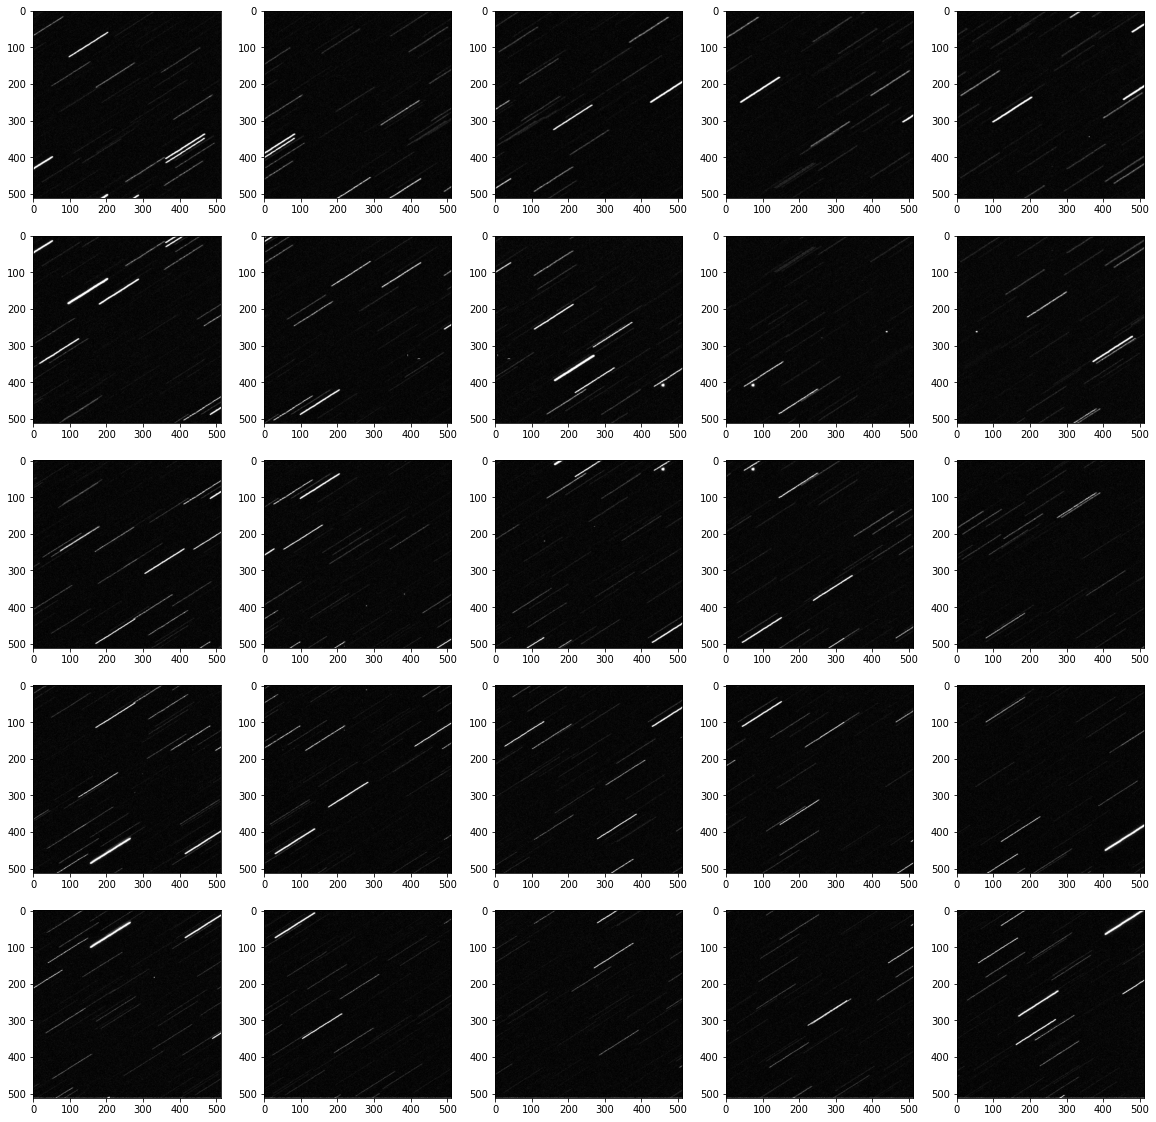

In [54]:
idx = 0
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
print(image_list[idx]['file_name'])
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(image_list[idx]['patches'][i, j, ...])

In [21]:
def draw_lines(image):
    for i in range(384, 2048 - 384, 384):
        image = cv2.line(image, (i, 0), (i, 2048), color=(255, 255, 255), thickness=1)
        image = cv2.line(image, (i + 128, 0), (i + 128, 2048), color=(255, 255, 255), thickness=1)

        image = cv2.line(image, (0, i), (2048, i), color=(255, 255, 255), thickness=1)
        image = cv2.line(image, (0, i + 128), (2048, i + 128), color=(255, 255, 255), thickness=1)
    return image

def convert_boxes(boxes):
    res = torch.clone(boxes)
    res[:, 2] = res[:, 2] - res[:, 0]
    res[:, 3] = res[:, 3] - res[:, 1]
    return res

def get_corners(rotated_boxes):
    x = rotated_boxes[:, 0]
    y = rotated_boxes[:, 1]
    w = rotated_boxes[:, 2]
    l = rotated_boxes[:, 3]
    yaw = rotated_boxes[:, 4] * math.pi / 180.0
    device = rotated_boxes.device
    bev_corners = torch.zeros((len(rotated_boxes), 4, 2), dtype=torch.float, device=device)
    cos_yaw = torch.cos(yaw)
    sin_yaw = torch.sin(yaw)
    # top left
    bev_corners[:, 0, 0] = x - w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[:, 0, 1] = y + w / 2 * sin_yaw - l / 2 * cos_yaw

    # bottom left
    bev_corners[:, 1, 0] = x - w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[:, 1, 1] = y + w / 2 * sin_yaw + l / 2 * cos_yaw

    # bottom right
    bev_corners[:, 2, 0] = x + w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[:, 2, 1] = y - w / 2 * sin_yaw + l / 2 * cos_yaw

    # top right
    bev_corners[:, 3, 0] = x + w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[:, 3, 1] = y - w / 2 * sin_yaw - l / 2 * cos_yaw
    
    return bev_corners

def get_polygons(bev_corners):
    list_of_polygons = []
    for i in range(len(bev_corners)):
        list_of_polygons.append(Polygon([(bev_corners[i, j, 0], bev_corners[i, j, 1]) for j in range(4)]).buffer(0))
    return list_of_polygons

def filter_boxes(image_data):
    indices_to_remove_list = []
    boxes = image_data['instances'].pred_boxes.tensor
    classes = image_data['instances'].pred_classes
    print(len(boxes))
    areas = image_data['instances'].pred_boxes.area().reshape(-1, 1)

    boxes_rows = convert_boxes(boxes)
    boxes_cols = convert_boxes(boxes)
    ious = get_iou_not_same_shape(boxes_cols, boxes_rows)
    ious[torch.eye(len(ious), dtype=torch.bool)] = 0
    indices_pair = torch.nonzero(ious > 0.25)
    #mask_ponctuels = (classes == 1).reshape(-1, 1)
    mask_ious = torch.any(ious > 0.05, dim=1).reshape(-1, 1)
    #mask_ponctuels_remove = torch.all(torch.cat([mask_ponctuels, mask_ious], dim=1), dim=1).reshape(-1, 1)

    areas_row = areas[indices_pair[:, 0]]
    areas_col = areas[indices_pair[:, 1]]
    whole_areas = torch.cat([areas_row, areas_col], dim=1)
    indices_to_remove = torch.min(whole_areas, dim=1)[1]
    indices_to_remove = torch.gather(indices_pair, 1, indices_to_remove.reshape(-1, 1)).reshape(-1)

    x0 = boxes[:, 0]
    y0 = boxes[:, 1]
    x1 = boxes[:, 2]
    y1 = boxes[:, 3]

    for i in range(384, 2048 - 384, 384):
        col1 = ((x0 > i) & (x0 < i + 128)).reshape(-1, 1)
        col2 = ((x1 > i) & (x1 < i + 128)).reshape(-1, 1)
        col3 = ((y0 > i) & (y0 < i + 128)).reshape(-1, 1)
        col4 = ((y1 > i) & (y1 < i + 128)).reshape(-1, 1)
        mask = torch.cat([col1, col2, col3, col4], dim=1)
        mask = torch.any(mask, dim=1).reshape(-1, 1)
        #mask_ponctuels = torch.all(torch.cat([mask_ponctuels_remove, mask], dim=1), dim=1)
        #indices_filtered_ponctuels = torch.nonzero(mask_ponctuels)[:, 0]
        mask = mask[indices_pair[:, 0]].reshape(-1)
        indices_filtered = indices_to_remove[mask]
        #indices_filtered = torch.cat([indices_filtered, indices_filtered_ponctuels])
        indices_to_remove_list.append(indices_filtered)
    indices_filter = torch.cat(indices_to_remove_list)
    indices_filter = torch.unique(indices_filter)
    print(len(indices_filter))

    index = torch.ones(boxes.shape[0], dtype=torch.bool)
    index[indices_filter] = False

    image_data['instances'].pred_boxes.tensor = image_data['instances'].pred_boxes.tensor[index]
    image_data['instances'].scores = image_data['instances'].scores[index]
    image_data['instances'].pred_classes = image_data['instances'].pred_classes[index]
    
    return image_data

def get_my_metric(polys_a, polys_b):
    table_metric = torch.zeros((len(polys_a), len(polys_b)), dtype=torch.float)
    for i, poly_row in enumerate(polys_a):
        for j, poly_col in enumerate(polys_b):
            intersection = poly_row.intersection(poly_col)
            intersection_area = intersection.area
            table_metric[i, j] = intersection_area / poly_row.area
    return table_metric

def get_iou_rotated(polys_a, polys_b):
    table_iou = torch.zeros((len(polys_a), len(polys_b)), dtype=torch.float)
    for i, poly_row in enumerate(polys_a):
        for j, poly_col in enumerate(polys_b):
            intersection = poly_row.intersection(poly_col)
            intersection_area = intersection.area
            union = poly_col.area + poly_row.area - intersection_area
            table_iou[i, j] = intersection_area / (union + 1e-16)
    return table_iou

def filter_boxes_rotated(image_data, thresh):
    indices_to_remove_list = []
    boxes = image_data['instances'].pred_boxes.tensor
    classes = image_data['instances'].pred_classes
    areas = image_data['instances'].pred_boxes.area().reshape(-1, 1)
    corners = get_corners(boxes)
    
    x0 = corners[:, 0, 0]
    y0 = corners[:, 0, 1]
    x1 = corners[:, 2, 0]
    y1 = corners[:, 2, 1]

    for i in range(384, 2048 - 384, 384):
        col1 = ((x0 > i) & (x0 < i + 128)).reshape(-1, 1)
        col2 = ((x1 > i) & (x1 < i + 128)).reshape(-1, 1)
        col3 = ((y0 > i) & (y0 < i + 128)).reshape(-1, 1)
        col4 = ((y1 > i) & (y1 < i + 128)).reshape(-1, 1)
        mask = torch.cat([col1, col2, col3, col4], dim=1)
        mask = torch.any(mask, dim=1).reshape(-1,)
        true_indices = torch.nonzero(mask)
        
        filtered_boxes = boxes[mask]
        filtered_areas = areas[mask]
        corners_filtered = corners[mask]
        
        polys = get_polygons(corners_filtered)
        ious = get_iou_rotated(polys, polys)
        ious[torch.eye(len(ious), dtype=torch.bool)] = 0
        indices_pair = torch.nonzero(ious > thresh)
        if indices_pair.numel() == 0:
            continue
        areas_row = filtered_areas[indices_pair[:, 0]]
        areas_col = filtered_areas[indices_pair[:, 1]]
        whole_areas = torch.cat([areas_row, areas_col], dim=1)
        indices_to_remove_filtered = torch.min(whole_areas, dim=1)[1]
        indices_to_remove_filtered = torch.gather(indices_pair, 1, indices_to_remove_filtered.reshape(-1, 1)).reshape(-1)
        
        indices_filtered = true_indices[indices_to_remove_filtered]
        
        indices_to_remove_list.append(indices_filtered)
    indices_filter = torch.cat(indices_to_remove_list)
    indices_filter = torch.unique(indices_filter)

    index = torch.ones(boxes.shape[0], dtype=torch.bool)
    index[indices_filter] = False

    image_data['instances'].pred_boxes.tensor = image_data['instances'].pred_boxes.tensor[index]
    image_data['instances'].scores = image_data['instances'].scores[index]
    image_data['instances'].pred_classes = image_data['instances'].pred_classes[index]
    
    return image_data

def filter_boxes_rotated2(image_data, thresh):
    classes_id = image_data['instances'].pred_classes
    boxes = image_data['instances'].pred_boxes.tensor
    indices_to_remove_list = []

    for i in range(3):
        current_mask = (classes_id == i)
        object_indices = torch.nonzero(current_mask)
        boxes_current = boxes[current_mask]
        areas = image_data['instances'].pred_boxes.area()[current_mask].reshape(-1, 1)
        corners = get_corners(boxes_current)
        
        x0 = corners[:, 0, 0]
        y0 = corners[:, 0, 1]
        x1 = corners[:, 2, 0]
        y1 = corners[:, 2, 1]

        for i in range(384, 2048 - 384, 384):
            col1 = ((x0 > i) & (x0 < i + 128)).reshape(-1, 1)
            col2 = ((x1 > i) & (x1 < i + 128)).reshape(-1, 1)
            col3 = ((y0 > i) & (y0 < i + 128)).reshape(-1, 1)
            col4 = ((y1 > i) & (y1 < i + 128)).reshape(-1, 1)
            mask = torch.cat([col1, col2, col3, col4], dim=1)
            mask = torch.any(mask, dim=1).reshape(-1,)
            true_indices = torch.nonzero(mask)
            
            filtered_areas = areas[mask]
            corners_filtered = corners[mask]
            
            polys = get_polygons(corners_filtered)
            metrics = get_my_metric(polys, polys)
            metrics[torch.eye(len(metrics), dtype=torch.bool)] = 0
            indices_pair = torch.nonzero(metrics > thresh)
            if indices_pair.numel() == 0:
                continue
            areas_row = filtered_areas[indices_pair[:, 0]]
            areas_col = filtered_areas[indices_pair[:, 1]]
            whole_areas = torch.cat([areas_row, areas_col], dim=1)
            indices_to_remove_filtered = torch.min(whole_areas, dim=1)[1]
            indices_to_remove_filtered = torch.gather(indices_pair, 1, indices_to_remove_filtered.reshape(-1, 1)).reshape(-1)
            
            indices_filtered = object_indices[true_indices[indices_to_remove_filtered]]
            
            indices_to_remove_list.append(indices_filtered)
    indices_filter = torch.cat(indices_to_remove_list)
    indices_filter = torch.unique(indices_filter)

    index = torch.ones(boxes.shape[0], dtype=torch.bool)
    index[indices_filter] = False

    image_data['instances'].pred_boxes.tensor = image_data['instances'].pred_boxes.tensor[index]
    image_data['instances'].scores = image_data['instances'].scores[index]
    image_data['instances'].pred_classes = image_data['instances'].pred_classes[index]
    
    return image_data

def filter_defilant(image_data, thresh):
    classes_id = image_data['instances'].pred_classes
    boxes = image_data['instances'].pred_boxes.tensor
    masks = []
    
    for i in range(3):
        current_mask = (classes_id == i)
        object_indices = torch.nonzero(current_mask)
        boxes_current = boxes[current_mask]
        areas = image_data['instances'].pred_boxes.area()[current_mask].reshape(-1, 1)
        corners = get_corners(boxes_current)
    
        polys = get_polygons(corners)
        metrics = get_my_metric(polys, polys)
        metrics[torch.eye(len(metrics), dtype=torch.bool)] = 0
        indices_pair = torch.nonzero(metrics > thresh)
        areas_row = areas[indices_pair[:, 0]]
        areas_col = areas[indices_pair[:, 1]]
        whole_areas = torch.cat([areas_row, areas_col], dim=1)
        indices_to_remove_filtered = torch.min(whole_areas, dim=1)[1]
        indices_to_remove_filtered = torch.gather(indices_pair, 1, indices_to_remove_filtered.reshape(-1, 1)).reshape(-1)
        mask_iou_smallest_area = zeros(len(boxes_defilant)).astype(np.bool)
        mask_iou_smallest_area[indices_to_remove_filtered] = True

        x0 = corners[:, 0, 0]
        y0 = corners[:, 0, 1]
        x1 = corners[:, 2, 0]
        y1 = corners[:, 2, 1]

        for i in range(384, 2048 - 384, 384):
            col1 = ((x0 > i) & (x0 < i + 128)).reshape(-1, 1)
            col2 = ((x1 > i) & (x1 < i + 128)).reshape(-1, 1)
            col3 = ((y0 > i) & (y0 < i + 128)).reshape(-1, 1)
            col4 = ((y1 > i) & (y1 < i + 128)).reshape(-1, 1)
            mask = torch.cat([col1, col2, col3, col4], dim=1)
            mask = torch.any(mask, dim=1)
            masks.append(mask)
    whole_mask = torch.cat(masks, dim=1)
    final_mask = torch.any(whole_mask, dim=1)
    final_mask = torch.all(torch.cat([final_mask, mask_iou_smallest_area], dim=1), dim=1)
    
    mask_defilant = ones(len(boxes)).astype(np.bool)
    mask_defilant[defilant_indices[final_mask]] = False

    image_data['instances'].pred_boxes.tensor = image_data['instances'].pred_boxes.tensor[mask_defilant]
    image_data['instances'].scores = image_data['instances'].scores[mask_defilant]
    image_data['instances'].pred_classes = image_data['instances'].pred_classes[mask_defilant]
    
    return image_data

In [22]:
def get_means(boxes, img):
    patches_mean_list = []
    corners = get_corners(boxes)
    for i in range(len(boxes)):
        current_box = boxes[i].reshape(-1,)
        angle = current_box[4].item()
        center = (current_box[0].item(), current_box[1].item())
        M = cv2.getRotationMatrix2D(center=center, angle=-angle, scale=1)
        img_rot = cv2.warpAffine(src=img, M=M, dsize=(img.shape[1], img.shape[0]))

        img_crop = cv2.getRectSubPix(img_rot, (int(current_box[2].item()), int(current_box[3].item())), center)
        patches_mean_list.append(img_crop.mean())
        plt.imshow(img_crop, cmap='gray')
        plt.show()
    means = torch.tensor(patches_mean_list)
    return means.reshape(-1, 1)

def get_means_shapely(boxes, img):
    patches_mean_list = []
    for i in range(len(boxes)):
        current_box = boxes[i].type(torch.int).reshape(-1,)
        img_crop = img[current_box[1]:current_box[3], current_box[0]:current_box[2]]
        patches_mean_list.append(img_crop.mean())
        plt.imshow(img_crop, cmap='gray')
        plt.show()
    means = torch.tensor(patches_mean_list)
    return means.reshape(-1, 1)

def filter_ponctuels(image_data, metric_thresh, score_thresh):
    boxes = image_data['instances'].pred_boxes.tensor
    classes = image_data['instances'].pred_classes
    scores = image_data['instances'].scores
    mask = (classes == 1).type(torch.bool)
    true_indices = torch.nonzero(mask)
    boxes_ponctuels = boxes[mask]
    scores_ponctuels = scores[mask]
    boxes_non_ponctuel = boxes[~mask]
    corners_ponctuels = get_corners(boxes_ponctuels)
    corners_non_ponctuel = get_corners(boxes_non_ponctuel)
    polys_ponctuels = get_polygons(corners_ponctuels)
    polys_non_ponctuels = get_polygons(corners_non_ponctuel)
    metrics = get_my_metric(polys_ponctuels, polys_non_ponctuels)
    indices_pair = torch.nonzero(metrics > metric_thresh)
    values, count = torch.unique(indices_pair[:, 0], return_counts=True)
    values = values[count > 1]
    ponctuel_overlap = boxes_ponctuels[indices_pair[:, 0]]
    ponctuel_overlap_scores = scores_ponctuels[indices_pair[:, 0]]
    other_overlap = boxes_non_ponctuel[indices_pair[:, 1]]
    score_mask = (ponctuel_overlap_scores < score_thresh)
    indices_to_remove = true_indices[indices_pair[:, 0][score_mask]]
    indices_to_remove = torch.unique(torch.cat([indices_to_remove, true_indices[values]], dim=0))
    
    index = torch.ones(boxes.shape[0], dtype=torch.bool)
    index[indices_to_remove] = False

    image_data['instances'].pred_boxes.tensor = image_data['instances'].pred_boxes.tensor[index]
    image_data['instances'].scores = image_data['instances'].scores[index]
    image_data['instances'].pred_classes = image_data['instances'].pred_classes[index]
    
    return image_data

In [23]:
dataset_test = DatasetCatalog.get("test")

Chargement des datasets: 100%|██████████| 1000/1000 [00:01<00:00, 581.23it/s]


/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210628_164525/png_data/848.png
CPU times: user 1.57 s, sys: 96 ms, total: 1.67 s
Wall time: 2.07 s


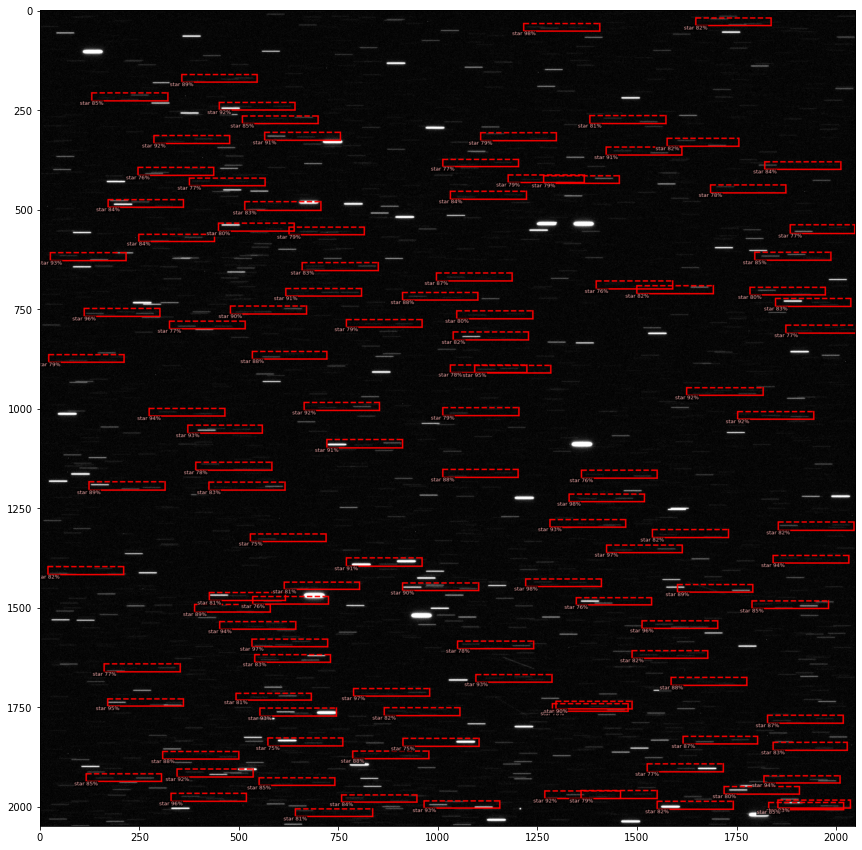

In [32]:
%%time

for d in random.sample(dataset_test, 1):
    output = {'instances': Instances((512, 512))}
    pred_boxes_list = []
    scores_list = []
    pred_classes_list = []
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    for idx, class_predictor in enumerate(predictors):
        out = class_predictor(im)
        if idx == 1 or idx == 2:
            boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
            pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
            pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
        else:
            pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
            pred_classes_list.append(out['instances'].pred_classes)
        scores_list.append(out['instances'].scores)
    
    output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
    output['instances'].scores = torch.cat(scores_list)
    output['instances'].pred_classes = torch.cat(pred_classes_list)
    output = filter_ponctuels(output, 0.4, 0.85)
    v = MyVisualizer(im[:, :, ::-1], metadata=metadatas, scale=1, instance_mode=ColorMode.SEGMENTATION)
    out = v.draw_instance_predictions(output["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]
    cv2.imwrite('/data_deep/SST_CNES_LOT2/out_img_simulator.png', out_img)
    show_image(out_img)

CPU times: user 1.45 s, sys: 43.7 ms, total: 1.49 s
Wall time: 1.5 s


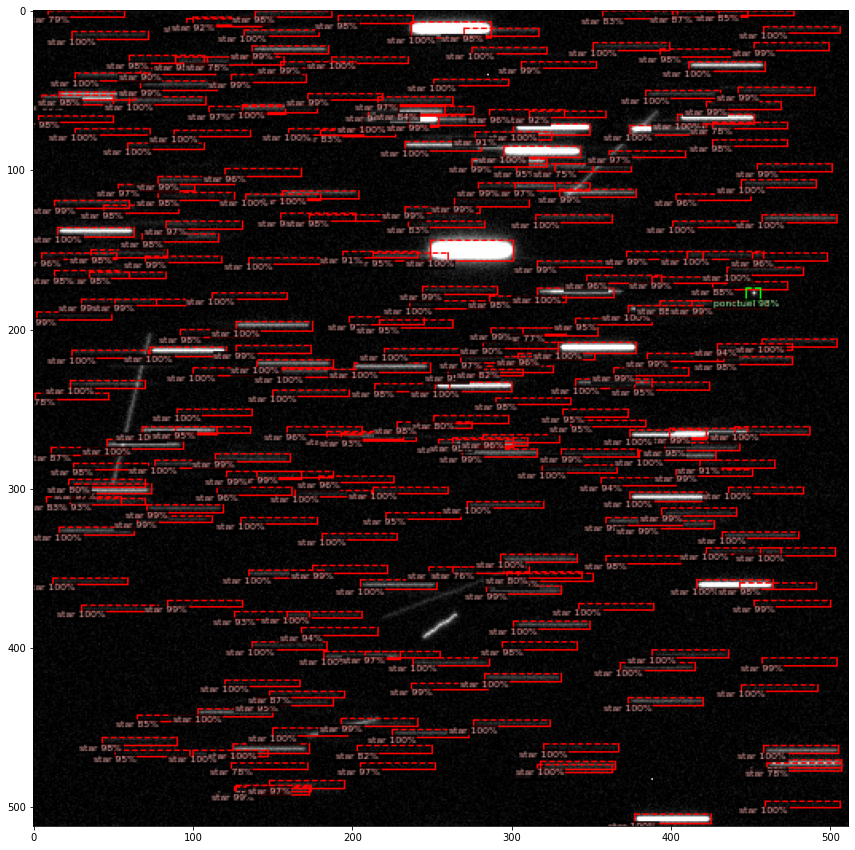

In [29]:
%%time
im = cv2.imread('/data_deep/SST_CNES_LOT2/Dataset_deep_earth_20210422_165028/IM_20210220_2201312473197_090_N05_010_0000000_1.png', cv2.IMREAD_COLOR)
output = {'instances': Instances((512, 512))}
pred_boxes_list = []
scores_list = []
pred_classes_list = []
for idx, class_predictor in enumerate(predictors):
    out = class_predictor(im)
    if idx == 1 or idx == 2:
        boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
        pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
        pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
    else:
        pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
        pred_classes_list.append(out['instances'].pred_classes)
    scores_list.append(out['instances'].scores)
    
output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
output['instances'].scores = torch.cat(scores_list)
output['instances'].pred_classes = torch.cat(pred_classes_list)
output = filter_ponctuels(output,  0.4, 0.9)
v = MyVisualizer(im[:, :, ::-1], metadata=metadatas, scale=1, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(output["instances"].to("cpu"))
out_img = out.get_image()[:, :, ::-1]
cv2.imwrite('/data_deep/SST_CNES_LOT2/out_img_test_2.png', out_img)
show_image(out_img)

In [24]:
def filter_visualization(big_output, class_number):
    boxes = big_output['instances'].pred_boxes.tensor
    classes = big_output['instances'].pred_classes
    scores = big_output['instances'].scores
    mask = (classes == class_number).type(torch.bool)
    big_output['instances'].pred_boxes.tensor = big_output['instances'].pred_boxes.tensor[mask]
    big_output['instances'].scores = big_output['instances'].scores[mask]
    big_output['instances'].pred_classes = big_output['instances'].pred_classes[mask]
    return big_output

/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


CPU times: user 2.71 s, sys: 231 ms, total: 2.94 s
Wall time: 2.01 s


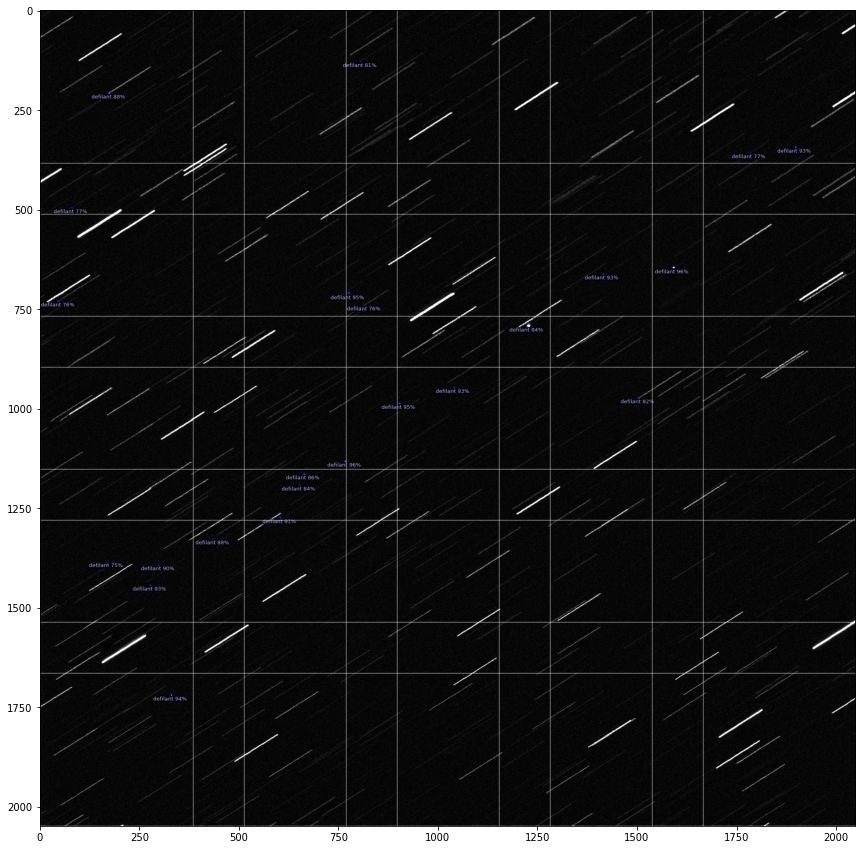

In [25]:
%%time

image_data = split_image('/data_deep/SST_CNES_LOT2/test_img_snr/png_images/image_0.png')
big_output = {'instances': Instances((2048, 2048))}
pred_boxes = []
scores = []
pred_classes = []
for i in range(5):
    for j in range(5):
        output = {'instances': Instances((512, 512))}
        pred_boxes_list = []
        scores_list = []
        pred_classes_list = []
        for idx, class_predictor in enumerate(predictors):
            out = class_predictor(image_data['patches'].numpy()[i, j, ...])
            boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
            pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
            pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
            scores_list.append(out['instances'].scores)
        
        output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
        output['instances'].scores = torch.cat(scores_list)
        output['instances'].pred_classes = torch.cat(pred_classes_list)

        output['instances'].pred_boxes.tensor[:, 0] += (j * 384)
        output['instances'].pred_boxes.tensor[:, 1] += (i * 384)
        pred_boxes.append(output['instances'].pred_boxes)
        scores.append(output['instances'].scores)
        pred_classes.append(output['instances'].pred_classes)
big_output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes)
big_output['instances'].scores = torch.cat(scores)
big_output['instances'].pred_classes = torch.cat(pred_classes)

big_output = filter_boxes_rotated2(big_output, 0.5)
#big_output = filter_boxes_rotated(big_output, 0.25)
#big_output = filter_ponctuels(big_output, 0.5, 0.85)

#print(big_output['instances'].pred_boxes.tensor[big_output['instances'].pred_classes == 0])

im = cv2.imread('/data_deep/SST_CNES_LOT2/test_img_snr/png_images/image_0.png')
    #big_output = filter_visualization(big_output, 1)

v = MyVisualizer(im[:, :, ::-1], metadata=metadatas, scale=1, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(big_output["instances"].to("cpu"))
out_im = out.get_image()[:, :, ::-1]
out_im = draw_lines(out_im.astype(np.float32)).astype(np.uint8)
converted = cv2.cvtColor(out_im, cv2.COLOR_RGB2BGR)
    #converted = np.flipud(converted)
cv2.imwrite('/data_deep/SST_CNES_LOT2/stage/out_im_filtered_overlap.png', converted)
show_image(out_im)

CPU times: user 14.8 s, sys: 1.3 s, total: 16.1 s
Wall time: 15.6 s


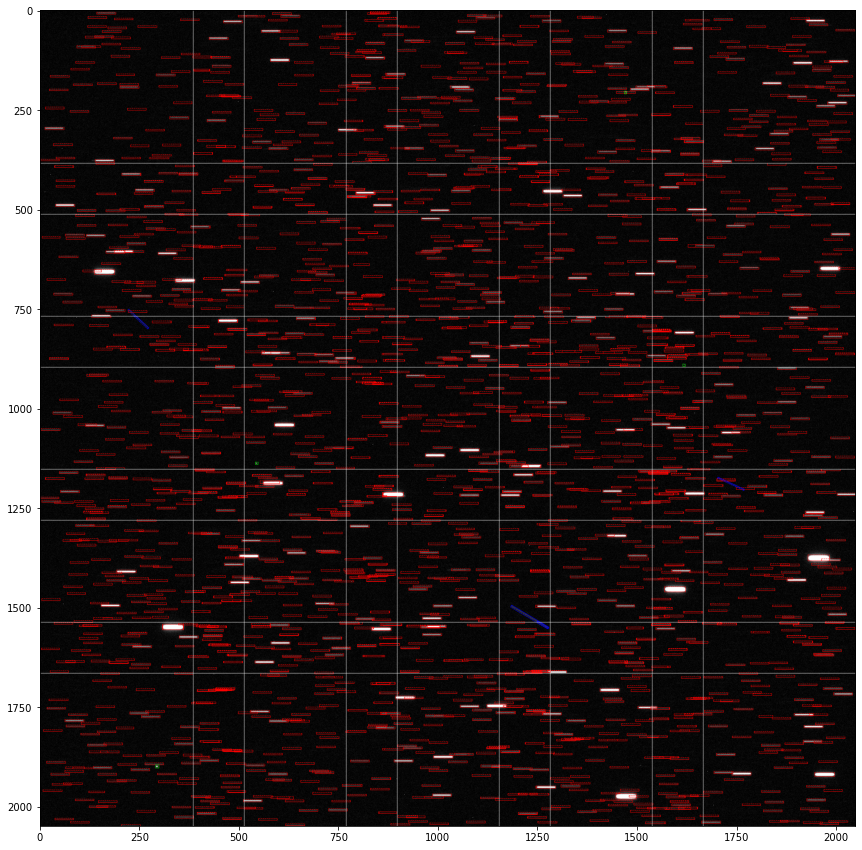

In [28]:
%%time

path = '/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/png_data/0.png'
image_data = split_image(path)
big_output = {'instances': Instances((2048, 2048))}
pred_boxes = []
scores = []
pred_classes = []
for i in range(5):
    for j in range(5):
        output = {'instances': Instances((512, 512))}
        pred_boxes_list = []
        scores_list = []
        pred_classes_list = []
        for idx, class_predictor in enumerate(predictors):
            out = class_predictor(image_data['patches'].numpy()[i, j, ...])
            if idx == 1 or idx == 2:
                boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
                pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
                pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
            else:
                pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
                pred_classes_list.append(out['instances'].pred_classes)
            scores_list.append(out['instances'].scores)

        output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
        output['instances'].scores = torch.cat(scores_list)
        output['instances'].pred_classes = torch.cat(pred_classes_list)

        output['instances'].pred_boxes.tensor[:, 0] += (j * 384)
        output['instances'].pred_boxes.tensor[:, 1] += (i * 384)
        pred_boxes.append(output['instances'].pred_boxes)
        scores.append(output['instances'].scores)
        pred_classes.append(output['instances'].pred_classes)
big_output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes)
big_output['instances'].scores = torch.cat(scores)
big_output['instances'].pred_classes = torch.cat(pred_classes)

#big_output = filter_boxes_rotated2(big_output, 0.5)
big_output = filter_ponctuels(big_output, 0.5, 0.85)

im = cv2.imread(path)
#big_output = filter_visualization(big_output, 1)

v = MyVisualizer(im[:, :, ::-1], metadata=metadatas, scale=1, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(big_output["instances"].to("cpu"))
out_im = out.get_image()[:, :, ::-1]
out_im = draw_lines(out_im.astype(np.float32)).astype(np.uint8)
converted = cv2.cvtColor(out_im, cv2.COLOR_RGB2BGR)
    #converted = np.flipud(converted)
cv2.imwrite('/data_deep/SST_CNES_LOT2/out_im_filtered_overlap_2.png', converted)
show_image(out_im)

/data_deep/SST_CNES_LOT2/DATASET_PERFO/Images_simulees/Dataset_deep_perfo_earth_20210708_102214/png_data/94.png
CPU times: user 1min 3s, sys: 1.28 s, total: 1min 4s
Wall time: 58.3 s


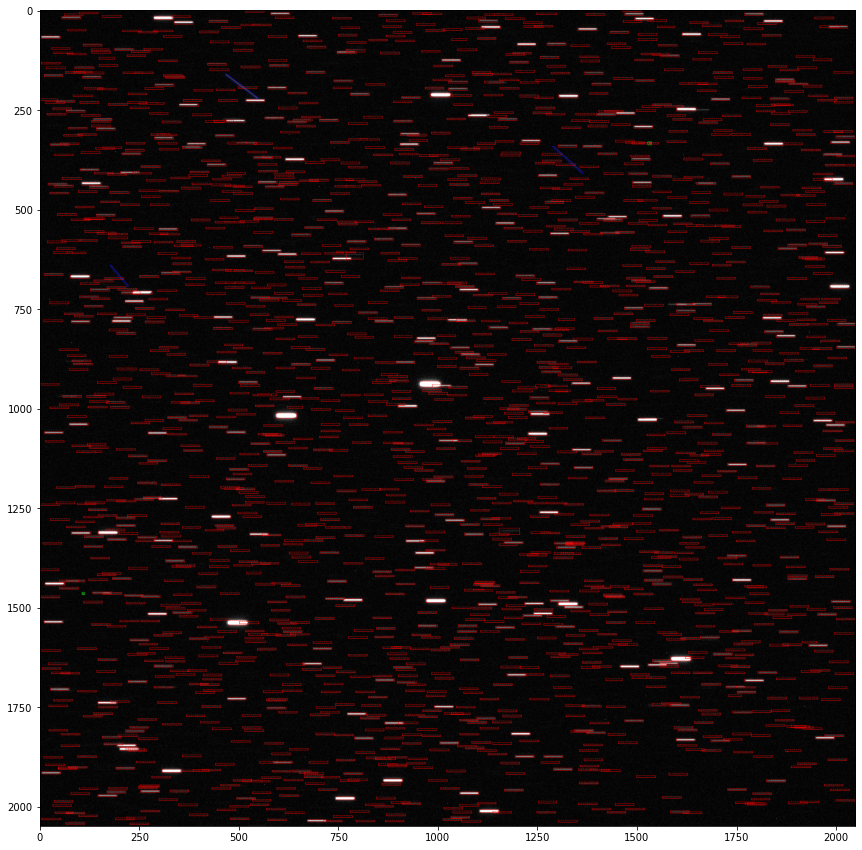

In [32]:
%%time

for d in random.sample(dataset_test, 1):
    print(d['file_name'])
    image_data = split_image(d["file_name"])
    big_output = {'instances': Instances((2048, 2048))}
    pred_boxes = []
    scores = []
    pred_classes = []
    for i in range(5):
        for j in range(5):
            output = {'instances': Instances((512, 512))}
            pred_boxes_list = []
            scores_list = []
            pred_classes_list = []
            for idx, class_predictor in enumerate(predictors):
                out = class_predictor(image_data['patches'].numpy()[i, j, ...])
                if idx == 1 or idx == 2:
                    boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
                    pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
                    pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
                else:
                    pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
                    pred_classes_list.append(out['instances'].pred_classes)
                scores_list.append(out['instances'].scores)

            output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
            output['instances'].scores = torch.cat(scores_list)
            output['instances'].pred_classes = torch.cat(pred_classes_list)

            output['instances'].pred_boxes.tensor[:, 0] += (j * 384)
            output['instances'].pred_boxes.tensor[:, 1] += (i * 384)
            pred_boxes.append(output['instances'].pred_boxes)
            scores.append(output['instances'].scores)
            pred_classes.append(output['instances'].pred_classes)
    big_output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes)
    big_output['instances'].scores = torch.cat(scores)
    big_output['instances'].pred_classes = torch.cat(pred_classes)

    big_output = filter_boxes_rotated2(big_output, 0.5)
    big_output = filter_ponctuels(big_output, 0.5, 0.85)

    im = cv2.imread(d["file_name"])
    #big_output = filter_visualization(big_output, 1)

    v = MyVisualizer(im[:, :, ::-1], metadata=metadatas, scale=1, instance_mode=ColorMode.SEGMENTATION)
    out = v.draw_instance_predictions(big_output["instances"].to("cpu"))
    out_im = out.get_image()[:, :, ::-1]
    out_im = draw_lines(out_im.astype(np.float32)).astype(np.uint8)
    converted = cv2.cvtColor(out_im, cv2.COLOR_RGB2BGR)
    #converted = np.flipud(converted)
    cv2.imwrite('/data_deep/SST_CNES_LOT2/out_im_filtered.png', converted)
    show_image(out_im)

In [45]:
def run_inference(dataset_test, classes, predictors, iou_thresh, path_out):
    metrics = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for d in tqdm(dataset_test):
        output = {'instances': Instances((512, 512))}
        pred_boxes_list = []
        scores_list = []
        pred_classes_list = []
        im = cv2.imread(d["file_name"])
        for idx, class_predictor in enumerate(predictors):
            out = class_predictor(im)
            if idx == 1 or idx == 2:
                boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
                pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)).to('cpu'))
                pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cpu'))
            else:
                pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
                pred_classes_list.append(out['instances'].pred_classes.to('cpu'))
            scores_list.append(out['instances'].scores.to('cpu'))

        output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
        output['instances'].scores = torch.cat(scores_list)
        output['instances'].pred_classes = torch.cat(pred_classes_list)
        output = filter_ponctuels(output, im, 0.4, 40, 0.85)

        objs = []
        gt_boxes = torch.empty((0, 5)).to('cpu')
        class_id_list = []
        class_ids = torch.empty((0, 1)).to('cpu')
        for obj in d['annotations']:
            objs.append(torch.tensor(BoxMode.convert(obj['bbox'], obj['bbox_mode'], BoxMode.XYWHA_ABS)).reshape(1, -1))
            class_id_list.append(obj['category_id'])
        if len(objs) > 0:
            gt_boxes = torch.cat(objs).to('cpu')
            class_ids = torch.tensor(class_id_list).to('cpu')

        class_gt = [gt_boxes[class_ids == 0], gt_boxes[class_ids == 1], gt_boxes[class_ids == 2]]
        pred_boxes = output['instances'].pred_boxes.tensor.to('cpu')
        pred_classes = output['instances'].pred_classes.to('cpu')
        class_preds = [pred_boxes[pred_classes == 0], pred_boxes[pred_classes == 1], pred_boxes[pred_classes == 2]]
        for gt_boxes, pred_boxes, class_metric in zip(class_gt, class_preds, metrics):
            corners_gt = get_corners(gt_boxes)
            corners_preds = get_corners(pred_boxes)
            polys_gt = get_polygons(corners_gt)
            polys_preds = get_polygons(corners_preds)
            ious = get_iou_rotated(polys_gt, polys_preds)
            if torch.numel(ious) == 0:
                class_metric[1] += ious.shape[1]
                class_metric[2] += ious.shape[0]
            else:
                class_metric[0] += torch.any(ious > iou_thresh, dim=0).sum()
                class_metric[1] += torch.all(ious < iou_thresh, dim=0).sum()
                class_metric[2] += torch.all(ious < iou_thresh, dim=1).sum()

    with open(os.path.join(path_out, 'metrics.txt'), 'w+') as fd:
        for name, class_metrics in zip(classes, metrics):
            fd.write(name + '\n\n')
            fd.write(f'tp: {class_metrics[0]}\n')
            fd.write(f'fp: {class_metrics[1]}\n')
            fd.write(f'fn: {class_metrics[2]}\n')
            fd.write(f'precision: {class_metrics[0] / (class_metrics[0] + class_metrics[1])}\n')
            fd.write(f'recall: {class_metrics[0] / (class_metrics[0] + class_metrics[2])}\n')
            fd.write(f'F1 score: {class_metrics[0] / (class_metrics[0] + 0.5 * (class_metrics[1] + class_metrics[2]))}\n')
            fd.write('\n\n')
    

run_inference(dataset_test, classes, predictors, 0.5, '/data_deep/SST_CNES_LOT2/output_earth')

100%|██████████| 1359/1359 [19:09<00:00,  1.18it/s]


In [ ]:
def remove_stars(big_output):
    mask = big_output['instances'].pred_classes != 2
    big_output['instances'].pred_boxes = big_output['instances'].pred_boxes[mask]
    big_output['instances'].scores = big_output['instances'].scores[mask]
    big_output['instances'].pred_classes = big_output['instances'].pred_classes[mask]
    return big_output

In [54]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(a.shape)
print(a[[True, False], [False, True, True]])

torch.Size([2, 3])
tensor([2, 3])


In [29]:
def run_inference(dataset_test, predictors, path_out):
    list_of_big_output = []
    for d in tqdm(dataset_test, desc='Running benchmark'):
        image_data = split_image(d["file_name"])
        big_output = {'instances': Instances((2048, 2048))}
        pred_boxes = []
        scores = []
        pred_classes = []
        for i in range(5):
            for j in range(5):
                output = {'instances': Instances((512, 512))}
                pred_boxes_list = []
                scores_list = []
                pred_classes_list = []
                for idx, class_predictor in enumerate(predictors):
                    out = class_predictor(image_data['patches'].numpy()[i, j, ...])
                    if idx == 1 or idx == 2:
                        boxes = BoxMode.convert(out['instances'].pred_boxes.tensor, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS).to('cpu')
                        pred_boxes_list.append(RotatedBoxes(BoxMode.convert(boxes, BoxMode.XYWH_ABS, BoxMode.XYWHA_ABS)))
                        pred_classes_list.append(torch.full(out['instances'].pred_classes.shape, idx, device='cuda:0'))
                    else:
                        pred_boxes_list.append(out['instances'].pred_boxes.to('cpu'))
                        pred_classes_list.append(out['instances'].pred_classes)
                    scores_list.append(out['instances'].scores)

                output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes_list)
                output['instances'].scores = torch.cat(scores_list)
                output['instances'].pred_classes = torch.cat(pred_classes_list)

                output['instances'].pred_boxes.tensor[:, 0] += (j * 384)
                output['instances'].pred_boxes.tensor[:, 1] += (i * 384)
                pred_boxes.append(output['instances'].pred_boxes)
                scores.append(output['instances'].scores)
                pred_classes.append(output['instances'].pred_classes)
        big_output['instances'].pred_boxes = RotatedBoxes.cat(pred_boxes)
        big_output['instances'].scores = torch.cat(scores)
        big_output['instances'].pred_classes = torch.cat(pred_classes)

        big_output = filter_boxes_rotated2(big_output, 0.5)
        big_output = filter_ponctuels(big_output, 0.5, 0.85)
        list_of_big_output.append(big_output)
        
        with open(os.path.join(path_out, 'output_inference.txt'), "wb") as fp:
            pickle.dump(list_of_big_output, fp)
    
run_inference(dataset_test, predictors, '/data_deep/SST_CNES_LOT2/stage/output_earth')

Running benchmark: 100%|██████████| 1000/1000 [14:14:15<00:00, 51.26s/it] 


In [30]:
def get_metrics_deep(dataset_test, path_out, classes, iou_thresh):
    with open(os.path.join(path_out, 'output_inference.txt'), "rb") as fp:
        list_of_big_output = pickle.load(fp)
    metrics = {classes[0]: {}, classes[1]: {}}
    for key in metrics.keys():
        metrics[key]['nb_per_snr'] = np.zeros(11)
        metrics[key]['tp_per_snr'] = np.zeros(11)
        metrics[key]['true_positives'] = 0
        metrics[key]['false_positives'] = 0
        metrics[key]['false_negatives'] = 0
    for big_output, d in tqdm(zip(list_of_big_output, dataset_test), total=len(list_of_big_output)):
        objs = []
        gt_boxes = torch.empty((0, 5)).to('cpu')
        class_id_list = []
        snr_list = []
        class_ids = torch.empty((0, 1)).to('cpu')
        snr_t = torch.empty((0, 1)).to('cpu')
        for obj in d['annotations']:
            objs.append(torch.tensor(BoxMode.convert(obj['bbox'], obj['bbox_mode'], BoxMode.XYWHA_ABS)).reshape(1, -1))
            class_id_list.append(obj['category_id'])
            snr_list.append(float(obj['snr']))
        if len(objs) > 0:
            gt_boxes = torch.cat(objs).to('cpu')
            class_ids = torch.tensor(class_id_list).to('cpu')
            snr_t = torch.tensor(snr_list).to('cpu')

        pred_classes = big_output['instances'].pred_classes.to('cpu')
        pred_boxes = big_output['instances'].pred_boxes.tensor.to('cpu')
        corners_preds = get_corners(pred_boxes)
        polys_preds = get_polygons(corners_preds)
        corners_gt = get_corners(gt_boxes)
        polys_gt = get_polygons(corners_gt)
        ious = get_iou_rotated(polys_gt, polys_preds)

        for idx, key in enumerate(metrics.keys()):
            snr_class = snr_t[class_ids == idx]
            ious_class = ious[class_ids == idx][:, pred_classes == idx]
            if torch.numel(ious_class) == 0:
                metrics[key]['false_positives'] += ious_class.shape[1]
                metrics[key]['false_negatives'] += ious_class.shape[0]
            else:
                metrics[key]['true_positives'] += torch.any(ious_class > iou_thresh, dim=0).sum()
                metrics[key]['false_positives'] += torch.all(ious_class < iou_thresh, dim=0).sum()
                metrics[key]['false_negatives'] += torch.all(ious_class < iou_thresh, dim=1).sum()
            for i in range(10):
                ious_snr = ious_class[(snr_class > i) & (snr_class < i + 1)]
                metrics[key]['nb_per_snr'][i] += len(ious_snr)
                metrics[key]['tp_per_snr'][i] += torch.any(ious_snr > iou_thresh, dim=0).sum()
            ious_snr = ious_class[snr_class > 10]
            metrics[key]['nb_per_snr'][10] += len(ious_snr)
            metrics[key]['tp_per_snr'][10] += torch.any(ious_snr > iou_thresh, dim=0).sum()
            
    with open(os.path.join(path_out, 'metrics_deep.txt'), "wb") as fp:
        pickle.dump(metrics, fp)
        
get_metrics_deep(dataset_test, '/data_deep/SST_CNES_LOT2/stage/output_earth', classes, 0.5)

100%|██████████| 1000/1000 [08:39<00:00,  1.92it/s]


In [26]:
def run_bench_triton(dataset_test, classes, iou_thresh, path_out, path_in):
    metrics = {classes[0]: {}, classes[1]: {}}
    for key in metrics.keys():
        metrics[key]['nb_per_snr'] = np.zeros(11)
        metrics[key]['tp_per_snr'] = np.zeros(11)
        metrics[key]['true_positives'] = 0
        metrics[key]['false_positives'] = 0
        metrics[key]['false_negatives'] = 0
    for d in tqdm(dataset_test, desc='Running benchmark'):
        objs = []
        gt_boxes = torch.empty((0, 4)).to('cpu')
        class_id_list = []
        snr_list = []
        class_ids = torch.empty((0, 1)).to('cpu')
        snr_t = torch.empty((0, 1)).to('cpu')
        for obj in d['annotations']:
            objs.append(torch.tensor(BoxMode.convert(obj['bbox'], obj['bbox_mode'], BoxMode.XYXY_ABS)).reshape(1, -1))
            class_id_list.append(obj['category_id'])
            snr_list.append(float(obj['snr']))
        if len(objs) > 0:
            gt_boxes = torch.cat(objs).to('cpu')
            class_ids = torch.tensor(class_id_list).to('cpu')
            snr_t = torch.tensor(snr_list).to('cpu')
        
        bbox_list = []
        class_id_list = []
        with open(os.path.join(path_in, d['file_name'].split('/')[-1].split('.')[0] + '.json')) as json_file:
            data = json.load(json_file)
            satellites = data['Objects']
            for satellite in satellites:
                x0, y0, x1, y1 = 0, 0, 0, 0
                if satellite['Type'] == 'ponctuel':
                    class_id_list.append(1)
                    x0 = float(satellite['x1']) - 3
                    x1 = float(satellite['x1']) + 3
                    y0 = float(satellite['y1']) - 3
                    y1 = float(satellite['y1']) + 3
                elif satellite['Type'] == 'defilant':
                    class_id_list.append(0)
                    if float(satellite['dx']) < 0:
                        x0 = float(satellite['x0']) + float(satellite['dx'])
                        x1 = float(satellite['x0'])
                    else:
                        x0 = float(satellite['x0'])
                        x1 = float(satellite['x0']) + float(satellite['dx'])
                    if float(satellite['dy']) < 0:
                        y0 = float(satellite['y0']) + float(satellite['dy'])
                        y1 = float(satellite['y0'])
                    else:
                        y0 = float(satellite['y0'])
                        y1 = float(satellite['y0']) + float(satellite['dy'])
                bbox_list.append(torch.tensor([x0, y0, x1, y1]).reshape(1, -1))
        
        if len(bbox_list) > 0:
            pred_boxes = torch.cat(bbox_list).to('cpu')
            pred_classes = torch.tensor(class_id_list).to('cpu')
        
        ious = pairwise_iou(Boxes(gt_boxes), Boxes(pred_boxes))
        
        for idx, key in enumerate(metrics.keys()):
            snr_class = snr_t[class_ids == idx]
            ious_class = ious[class_ids == idx][:, pred_classes == idx]
            if torch.numel(ious_class) == 0:
                metrics[key]['false_positives'] += ious_class.shape[1]
                metrics[key]['false_negatives'] += ious_class.shape[0]
            else:
                metrics[key]['true_positives'] += torch.any(ious_class > iou_thresh, dim=0).sum()
                metrics[key]['false_positives'] += torch.all(ious_class < iou_thresh, dim=0).sum()
                metrics[key]['false_negatives'] += torch.all(ious_class < iou_thresh, dim=1).sum()
            for i in range(10):
                ious_snr = ious_class[(snr_class > i) & (snr_class < i + 1)]
                metrics[key]['nb_per_snr'][i] += len(ious_snr)
                metrics[key]['tp_per_snr'][i] += torch.any(ious_snr > iou_thresh, dim=0).sum()
            ious_snr = ious_class[snr_class > 10]
            metrics[key]['nb_per_snr'][10] += len(ious_snr)
            metrics[key]['tp_per_snr'][10] += torch.any(ious_snr > iou_thresh, dim=0).sum()
        
    with open(os.path.join(path_out, 'metrics_triton.txt'), "wb") as fp:
        pickle.dump(metrics, fp)
    
run_bench_triton(dataset_test, classes, 0.5, '/data_deep/SST_CNES_LOT2/stage/output_earth', '/data_deep/SST_CNES_LOT2/Resultats_Triton_deep_perfo_earth_20210708_102214/json_data')

Running benchmark: 100%|██████████| 1000/1000 [00:06<00:00, 148.37it/s]


<ipython-input-31-4f317b82829b>:35: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][classes[1]][i] = (metrics[classes[1]]['tp_per_snr'][i] / metrics[classes[1]]['nb_per_snr'][i]) * 100
<ipython-input-31-4f317b82829b>:35: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][classes[1]][i] = (metrics[classes[1]]['tp_per_snr'][i] / metrics[classes[1]]['nb_per_snr'][i]) * 100


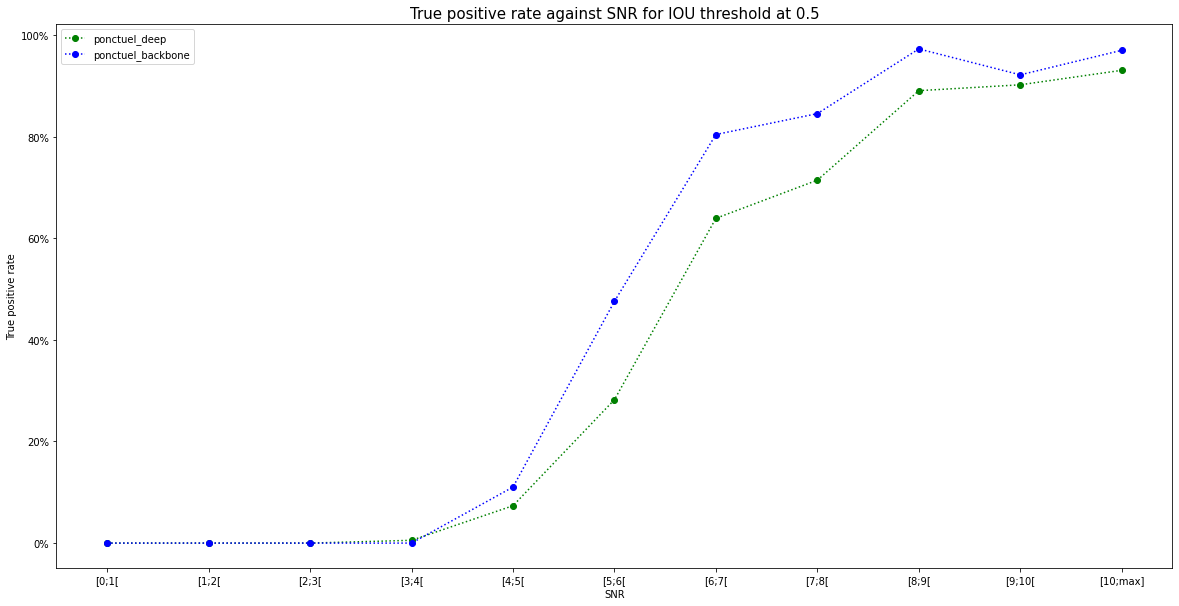

In [31]:
def write_metrics_comparison(classes, path_in_backbone, path_in, iou_thresh):
    fontdict = {'fontsize': 15,
 'fontweight' : rcParams['axes.titleweight'],
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}
    with open(os.path.join(path_in_backbone, 'metrics_deep.txt'), "rb") as fp:
        metrics_backbone = pickle.load(fp)
    with open(os.path.join(path_in, 'metrics_deep.txt'), "rb") as fp:
        metrics_deep = pickle.load(fp)
    labels = ['[0;1[', '[1;2[', '[2;3[', '[3;4[', '[4;5[', '[5;6[', '[6;7[', '[7;8[', '[8;9[', '[9;10[', '[10;max]']
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    #fig.suptitle(f'True positive rate against SNR for IOU threshold at {iou_thresh}', y=0.98, fontsize=25)
    ratios = {'deep': {}, 'backbone': {}}
    for key in ratios.keys():
        ratios[key] = {classes[1]: np.zeros(11)}
    for index, (metrics, method, col) in enumerate(zip([metrics_deep, metrics_backbone], ['deep', 'backbone'], ['g', 'b'])):
        ax.set_title(f'True positive rate against SNR for IOU threshold at {iou_thresh}', fontdict=fontdict)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_xlabel('SNR')
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_ylabel('True positive rate')
        with open(os.path.join(path_in_backbone, 'results_' + method + '.txt'), 'w+') as fd:
            precision = metrics[classes[1]]['true_positives'] / (metrics[classes[1]]['true_positives'] + metrics[classes[1]]['false_positives'])
            recall = metrics[classes[1]]['true_positives'] / (metrics[classes[1]]['true_positives'] + metrics[classes[1]]['false_negatives'])
            f1_score = metrics[classes[1]]['true_positives'] / (metrics[classes[1]]['true_positives'] + 0.5 * (metrics[classes[1]]['false_positives'] + metrics[classes[1]]['false_negatives']))
            fd.write(classes[1] + '\n\n')
            fd.write('tp: {}\n'.format(metrics[classes[1]]['true_positives']))
            fd.write('fp: {}\n'.format(metrics[classes[1]]['false_positives']))
            fd.write('fn: {}\n'.format(metrics[classes[1]]['false_negatives']))
            fd.write('precision: {}\n'.format(precision))
            fd.write('recall: {}\n'.format(recall))
            fd.write('F1 score: {}\n\n'.format(f1_score))
            for i in range(10):
                ratios[method][classes[1]][i] = (metrics[classes[1]]['tp_per_snr'][i] / metrics[classes[1]]['nb_per_snr'][i]) * 100
                fd.write(f'snr {i}-{i + 1}\n')
                fd.write('True positives rate: {}%\n\n'.format(ratios[method][classes[1]][i]))
            ratios[method][classes[1]][10] = (metrics[classes[1]]['tp_per_snr'][10] / metrics[classes[1]]['nb_per_snr'][10]) * 100
            fd.write('snr 10+\n')
            fd.write('True positives rate: {}%\n\n'.format(ratios[method][classes[1]][10]))
            fd.write('\n\n')
            ax.plot(range(len(ratios[method][classes[1]])), np.nan_to_num(ratios[method][classes[1]]), ':', marker='o', color=col, label='ponctuel_' + method)
            ax.legend(loc="upper left")
        
    fig.savefig(os.path.join(path_in_backbone, 'plot.png'), dpi=fig.dpi)
    plt.show()
    
write_metrics_comparison(classes, '/data_deep/SST_CNES_LOT2/stage/output_earth_backbone', '/data_deep/SST_CNES_LOT2/stage/output_earth', 0.5)

<ipython-input-27-04b2129d00cc>:36: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][key][i] = (metrics[key]['tp_per_snr'][i] / metrics[key]['nb_per_snr'][i]) * 100
<ipython-input-27-04b2129d00cc>:36: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][key][i] = (metrics[key]['tp_per_snr'][i] / metrics[key]['nb_per_snr'][i]) * 100
<ipython-input-27-04b2129d00cc>:36: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][key][i] = (metrics[key]['tp_per_snr'][i] / metrics[key]['nb_per_snr'][i]) * 100
<ipython-input-27-04b2129d00cc>:36: RuntimeWarning: invalid value encountered in double_scalars
  ratios[method][key][i] = (metrics[key]['tp_per_snr'][i] / metrics[key]['nb_per_snr'][i]) * 100


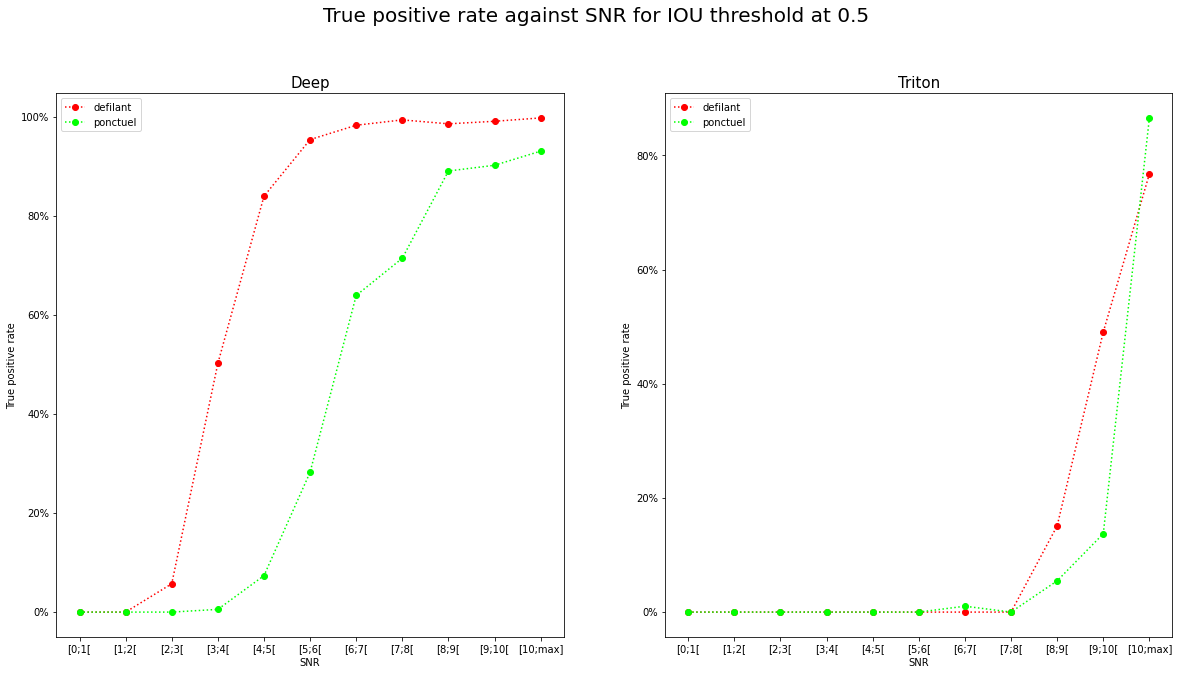

In [27]:
def write_metrics(classes, path_in, iou_thresh):
    fontdict = {'fontsize': 15,
 'fontweight' : rcParams['axes.titleweight'],
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}
    with open(os.path.join(path_in, 'metrics_deep.txt'), "rb") as fp:
        metrics_deep = pickle.load(fp)
    with open(os.path.join(path_in, 'metrics_triton.txt'), "rb") as fp:
        metrics_triton = pickle.load(fp)
    labels = ['[0;1[', '[1;2[', '[2;3[', '[3;4[', '[4;5[', '[5;6[', '[6;7[', '[7;8[', '[8;9[', '[9;10[', '[10;max]']
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f'True positive rate against SNR for IOU threshold at {iou_thresh}', y=1, fontsize=20)
    ratios = {'deep': {}, 'triton': {}}
    for key in ratios.keys():
        ratios[key] = {classes[0]: np.zeros(11), classes[1]: np.zeros(11)}
    for index, (metrics, method) in enumerate(zip([metrics_deep, metrics_triton], ['deep', 'triton'])):
        ax[index].set_title(f'{method}'.title(), fontdict=fontdict)
        ax[index].set_xticks(range(len(labels)))
        ax[index].set_xticklabels(labels)
        ax[index].set_xlabel('SNR')
        ax[index].yaxis.set_major_formatter(PercentFormatter())
        ax[index].set_ylabel('True positive rate')
        with open(os.path.join(path_in, 'results_' + method + '.txt'), 'w+') as fd:
            for idx, key in enumerate(metrics.keys()):
                precision = metrics[key]['true_positives'] / (metrics[key]['true_positives'] + metrics[key]['false_positives'])
                recall = metrics[key]['true_positives'] / (metrics[key]['true_positives'] + metrics[key]['false_negatives'])
                f1_score = metrics[key]['true_positives'] / (metrics[key]['true_positives'] + 0.5 * (metrics[key]['false_positives'] + metrics[key]['false_negatives']))
                fd.write(key + '\n\n')
                fd.write('tp: {}\n'.format(metrics[key]['true_positives']))
                fd.write('fp: {}\n'.format(metrics[key]['false_positives']))
                fd.write('fn: {}\n'.format(metrics[key]['false_negatives']))
                fd.write('precision: {}\n'.format(precision))
                fd.write('recall: {}\n'.format(recall))
                fd.write('F1 score: {}\n\n'.format(f1_score))
                for i in range(10):
                    ratios[method][key][i] = (metrics[key]['tp_per_snr'][i] / metrics[key]['nb_per_snr'][i]) * 100
                    fd.write(f'snr {i}-{i + 1}\n')
                    fd.write('True positives rate: {}%\n\n'.format(ratios[method][key][i]))
                ratios[method][key][10] = (metrics[key]['tp_per_snr'][10] / metrics[key]['nb_per_snr'][10]) * 100
                fd.write('snr 10+\n')
                fd.write('True positives rate: {}%\n\n'.format(ratios[method][key][10]))
                fd.write('\n\n')
                ax[index].plot(range(len(ratios[method][key])), np.nan_to_num(ratios[method][key]), ':', marker='o', color=tuple(t / 255 for t in colors[idx]), label=key)
                ax[index].legend(loc="upper left")
        
    fig.savefig(os.path.join(path_in, 'plot.png'), dpi=fig.dpi)
    plt.show()
    
write_metrics(classes, '/data_deep/SST_CNES_LOT2/stage/output_earth', 0.5)

In [123]:
from detectron2.evaluation import DatasetEvaluator

def get_gt_boxes_defilants(filepath):
    bboxes = []
    with open(filepath) as json_file:
        data = json.load(json_file)
        satellites = data['Objects']
        for satellite in satellites:
            if satellite['Type'] != 'defilant':
                continue
            margin = 4
            bboxes.append(torch.tensor([int(satellite['x0'] - margin), int(satellite['y0'] - margin), int(satellite['dx'] + 2 * margin), int(satellite['dy'] + 2 * margin)]).reshape(1, -1))
    if len(bboxes) == 0:
        return torch.empty((0, 4))          
    return torch.cat(bboxes)
    
def get_gt_boxes_ponctuels(filepath):
    bboxes = []
    with open(filepath) as json_file:
        data = json.load(json_file)
        satellites = data['Objects']
        for satellite in satellites:
            if satellite['Type'] == 'defilant':
                continue
            margin = -1.0 * satellite['mag'] + 22
            bboxes.append(torch.tensor([int(round(satellite['x0'] - margin)), int(round(satellite['y0'] - margin)), int(round(2 * margin)), int(round(2 * margin))]).reshape(1, -1))
    if len(bboxes) == 0:
        return torch.torch.empty((0, 4))
    return torch.cat(bboxes)

def get_gt_boxes_stars(filepath):
    df = pd.read_csv('data_earth_stars/csv_data/IM_20210221_2201312473197_060_N05_010_0000000_1_star_positions.csv', sep=';', usecols=['X0', 'Y0', 'X1', 'Y1', 'Gmag'])
    margin = (45 * np.exp(-0.2 * df['Gmag']) + 1).astype(int)
    width = (df['X0'] - df['X1']).astype(int) + 2 * margin
    height = (125 * np.exp(-0.25 * df['Gmag']) + 8).astype(int)
    #height = (-60 * np.log10(df['Gmag']) + 85).astype(int)
    X = (df['X1'] - margin).astype(int)
    Y = (df['Y1'] - (height / 2)).astype(int)
    bbox = pd.concat([X, Y, width, height], axis=1)
    df['bbox'] = bbox.values.tolist()
    res = torch.cat([torch.tensor(x).reshape(1, -1) for x in df['bbox'].values])
    if len(res) == 0:
        return torch.empty((0, 4))
    return res

class Counter(DatasetEvaluator):
    def __init__(self, dataset_name, iou_thresh, confidence_thresh):
        self.dataset_name = dataset_name
        self.iou_thresh = iou_thresh
        self.confidence_thresh = confidence_thresh
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def reset(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def process(self, inputs, outputs):
        gt_boxes = torch.empty((0, 4))
        for input_image, output in zip(inputs, outputs):
            if 'defilant' in self.dataset_name:
                filepath = input_image['file_name'].split('/')
                filepath[-2] = 'json_data'
                filepath[-1] = filepath[-1][:-4] + '_sat_positions.json'
                gt_boxes = get_gt_boxes_defilants('/'.join(filepath))
            elif 'ponctuel' in self.dataset_name:
                filepath = input_image['file_name'].split('/')
                filepath[-2] = 'json_data'
                filepath[-1] = filepath[-1][:-4] + '_sat_positions.json'
                gt_boxes = get_gt_boxes_defilants('/'.join(filepath))
            else:
                filepath = input_image['file_name'].split('/')
                filepath[-2] = 'csv_data'
                filepath[-1] = filepath[-1][:-4] + '_star_positions.csv'
                gt_boxes = get_gt_boxes_stars('/'.join(filepath))
            gt_boxes = gt_boxes.to('cuda:0')
            mask = (output['instances'].scores > self.confidence_thresh)
            #mask = torch.zeros(output['instances'].pred_boxes.tensor.shape[0], dtype=torch.bool)
            preds = output['instances'].pred_boxes[mask].tensor
            ious = get_iou_not_same_shape(gt_boxes, preds)
            if torch.numel(ious) == 0:
                self.fp += ious.shape[0]
                self.fn += ious.shape[1]
            else:
                self.tp += torch.any(ious > self.iou_thresh, dim=1).sum()
                self.fp += torch.all(ious < self.iou_thresh, dim=1).sum()
                self.fn += torch.all(ious < self.iou_thresh, dim=0).sum()

    def evaluate(self):
        # save self.count somewhere, or print it, or return it.
        print(f'tp: {self.tp}')
        print(f'fp: {self.fp}')
        print(f'fn: {self.fn}')

In [121]:
for cfg_class, name, trainer in zip(cfgs, ['defilant', 'ponctuel', 'star'], trainers):
    #evaluator = COCOEvaluator("test_" + name, ("bbox",), False, output_dir=cfg_class.OUTPUT_DIR)
    evaluator = Counter("test_" + name, 0.5, cfg_class.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
    test_loader = build_detection_test_loader(cfg_class, "test_" + name)
    print(inference_on_dataset(trainer.model, test_loader, evaluator))

[05/07 15:14:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(512, 512), max_size=512, sample_style='choice')]
[05/07 15:14:05 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[05/07 15:14:05 d2.data.common]: Serialized dataset takes 0.03 MiB
[05/07 15:14:05 d2.evaluation.evaluator]: Start inference on 100 batches
tensor([], device='cuda:0', size=(0, 4))
tensor([], device='cuda:0', size=(0, 3))
tensor([], device='cuda:0', size=(0, 3))
tensor([], device='cuda:0', size=(0, 5))
tensor([], device='cuda:0', size=(0, 3))
tensor([], device='cuda:0', size=(0, 2))
tensor([], device='cuda:0', size=(0, 3))
tensor([], device='cuda:0', size=(0, 1))
tensor([], device='cuda:0', size=(0, 3))
tensor([], device='cuda:0', size=(0, 0))
tensor([], device='cuda:0', size=(0, 1))
[05/07 15:14:06 d2.evaluation.evaluator]: Inference done 11/100. 0.0692 s / iter. ETA=0:00:06
tensor([], device='cuda:0', size

KeyboardInterrupt: 

In [18]:
evaluator = COCOEvaluator("test", ("bbox",), False, output_dir="output")
test_loader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(trainer.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/05 12:43:29 d2.evaluation.coco_evaluation]: 'test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[05/05 12:43:29 d2.data.datasets.coco]: Converting annotations of dataset 'test' to COCO format ...)
[05/05 12:43:30 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/05 12:43:31 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 12769
[05/05 12:43:31 d2.data.datasets.coco]: Caching COCO format annotations at 'output/test_coco_format.json' ...
[05/05 12:43:32 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  defilant  | 270          |  ponctuel  | 293          |   etoile   | 12206        |
|            |              |            |              |            |              |
|   total    | 12769        |    